In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [3]:
# Activation functions
def sigmoid(Z):
  return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(A):
  return A * (1 - A)

def relu(x):
  return np.maximum(0,x)

def relu_derivative(x):
  return (x > 0).astype(float)

def tanh(x):
  return np.tanh(x)

def tanh_derivative(x):
  return 1 - np.tanh(x)**2

def softmax(Z):
  expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # to prevent overflow
  return expZ / np.sum(expZ, axis=0, keepdims=True)

In [4]:
# Initialize parameters
def initialize_parameters(layer_sizes):
  parameters = {}
  num_of_layers = len(layer_sizes)

  for i in range(1, num_of_layers):
    parameters[f'W{i}'] = np.random.randn(layer_sizes[i], layer_sizes[i-1]) * np.sqrt(2 / layer_sizes[i-1])
    parameters[f'b{i}'] = np.zeros((layer_sizes[i], 1))
    parameters[f'gamma{i}'] = np.ones((layer_sizes[i], 1))  # Scale parameter for batch norm
    parameters[f'beta{i}'] = np.zeros((layer_sizes[i], 1))  # Shift parameter for batch norm

  return parameters

# Forward Propogation
def forward_propagation(X, parameters, activations, is_training=True, batch_norm_cache=None):
  A = X
  caches = []
  num_layers = len(activations)
  if batch_norm_cache is None:
    batch_norm_cache = {}

  for i in range(1, num_layers + 1):
    W = parameters[f'W{i}']
    b = parameters[f'b{i}']
    Z = np.dot(W,A) + b

    # Batch normalization
    if is_training:
      mu = np.mean(Z, axis=1, keepdims=True)
      var = np.var(Z, axis=1, keepdims=True)
      Z_norm = (Z - mu) / np.sqrt(var + 1e-8)
      Z_tilde = parameters[f'gamma{i}'] * Z_norm + parameters[f'beta{i}']
      batch_norm_cache[f'mu{i}'] = mu
      batch_norm_cache[f'var{i}'] = var
      batch_norm_cache[f'Z_norm{i}'] = Z_norm
    else:

      Z_norm = (Z - batch_norm_cache[f'mu{i}']) / np.sqrt(batch_norm_cache[f'var{i}'] + 1e-8)
      Z_tilde = parameters[f'gamma{i}'] * Z_norm + parameters[f'beta{i}']


    if(activations[i-1] == "sigmoid"):
      A = sigmoid(Z_tilde)
    elif(activations[i-1] == "relu"):
      A = relu(Z_tilde)
    elif(activations[i-1] == "tanh"):
      A = tanh(Z_tilde)
    elif(activations[i-1] == "softmax"):
      A = softmax(Z_tilde)

    caches.append({"Z":Z, "A":A, "W":W, "b": b, "Z_norm":Z_norm, "gamma":parameters[f'gamma{i}'], "beta": parameters[f'beta{i}']})

  return A, caches, batch_norm_cache

# Loss compute
def compute_loss(y,A):
  m = y.shape[1]
  loss = -np.sum(y*np.log(A+1e-8))/m
  return loss


# Back propogation
def back_propagation(X, y, caches, activations, batch_norm_cache):
  grads = {}
  gradient_magnitudes = {}
  m = X.shape[1]
  num_layers = len(caches)

  # Computing gradients for the output layer
  A_last = caches[-1]["A"]
  dA = A_last - y

  for i in reversed(range(num_layers)):
    Z, A, W, b, Z_norm, gamma, beta = caches[i]["Z"], caches[i]["A"], caches[i]["W"], caches[i]["b"], caches[i]["Z_norm"], caches[i]["gamma"], caches[i]["beta"]

    if(activations[i] == "sigmoid"):
      dZ_tilde = dA * sigmoid_derivative(A)
    elif(activations[i] == "relu"):
      dZ_tilde = dA * relu_derivative(A)
    elif(activations[i] == "tanh"):
      dZ_tilde = dA * tanh_derivative(A)
    elif(activations[i] == "softmax"):
      dZ_tilde = dA

    # Gradients for batch normalization
    dZ_norm = dZ_tilde * gamma
    dvar = np.sum(dZ_norm * (Z - batch_norm_cache[f'mu{i+1}']) * (-0.5) * (batch_norm_cache[f'var{i+1}'] + 1e-8)**(-1.5), axis=1, keepdims=True)
    dmu = np.sum(dZ_norm * (-1 / np.sqrt(batch_norm_cache[f'var{i+1}'] + 1e-8)), axis=1, keepdims=True) + dvar * np.mean(-2 * (Z - batch_norm_cache[f'mu{i+1}']), axis=1, keepdims=True)
    dZ = dZ_norm / np.sqrt(batch_norm_cache[f'var{i+1}'] + 1e-8) + dvar * 2 * (Z - batch_norm_cache[f'mu{i+1}']) / m + dmu / m

    dW = np.dot(dZ, caches[i-1]["A"].T) / m if i > 0 else np.dot(dZ, X.T)/m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dgamma = np.sum(dZ_tilde * Z_norm, axis=1, keepdims=True) / m
    dbeta = np.sum(dZ_tilde, axis=1, keepdims=True) / m

    grads[f'dW{i+1}'] = dW
    grads[f'db{i+1}'] = db
    grads[f'dgamma{i+1}'] = dgamma
    grads[f'dbeta{i+1}'] = dbeta


    # Compute gradient magnitude for the current layer
    gradient_magnitudes[f'layer{i+1}'] = np.linalg.norm(dW)  # Use Frobenius norm for dW
    dA = np.dot(W.T, dZ) if i > 0 else None

  return grads, gradient_magnitudes

# Update parameters
def update_parameters(parameters, grads, learning_rate):
  num_layers = len(parameters) // 4

  for i in range(1,num_layers + 1):

    # print(f"Layer {i}: W{i} shape {parameters[f'W{i}'].shape}, dW{i} shape {grads[f'dW{i}'].shape}")  # Debugging
    # print(f"Layer {i}: b{i} shape {parameters[f'b{i}'].shape}, db{i} shape {grads[f'db{i}'].shape}")  # Debugging

    #grads[f'dW{i}'] = grads[f'dW{i}'].T
    parameters[f'W{i}'] -= learning_rate * grads[f'dW{i}']
    parameters[f'b{i}'] -= learning_rate * grads[f'db{i}']
    parameters[f'gamma{i}'] -= learning_rate * grads[f'dgamma{i}']
    parameters[f'beta{i}'] -= learning_rate * grads[f'dbeta{i}']

  return parameters

# Compute accuracy
def compute_accuracy(y_true, A_pred):
  y_pred = np.argmax(A_pred, axis=0)
  y_true_labels = np.argmax(y_true, axis=0)
  accuracy = np.mean(y_pred == y_true_labels)*100  # Accuracy in percentage
  return accuracy

# Train Neural Network
def train_neural_network(X_train, y_train, layer_sizes, activations, num_epochs=100, learning_rate=0.01):
  loss_history = []
  accuracy_history = []
  parameters = initialize_parameters(layer_sizes)
  batch_norm_cache = {}
  gradient_magnitudes_history = {f'layer{i+1}': [] for i in range(len(layer_sizes) - 1)}  # To store gradient magnitudes for each layer
  for epoch in range(num_epochs):
    # Forward propogation
    A, caches, batch_norm_cache = forward_propagation(X_train, parameters, activations, is_training=True)

    # Compute loss
    loss = compute_loss(y_train, A)
    loss_history.append(loss)

    # Compute accuracy
    accuracy = compute_accuracy(y_train, A)
    accuracy_history.append(accuracy)

    # Backward propagation
    grads, gradient_magnitudes = back_propagation(X_train, y_train, caches, activations, batch_norm_cache)

    # Update parameters
    parameters = update_parameters(parameters, grads, learning_rate)

    # Print loss and accuracy every 10 epochs
    if(epoch % 10 == 0):
      print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Store gradient magnitudes for each layer
    for layer in gradient_magnitudes:
      gradient_magnitudes_history[layer].append(gradient_magnitudes[layer])

  # Plot loss and accuracy curves
  plt.figure(figsize=(12,5))

  # Loss curve
  plt.subplot(1, 2, 1)
  plt.plot(range(num_epochs), loss_history, label="Loss", color="red")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss Curve")
  plt.legend()

  # Accuracy Curve
  plt.subplot(1, 2, 2)
  plt.plot(range(num_epochs), accuracy_history, label="Accuracy", color="blue")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy (%)")
  plt.title("Accuracy Curve")
  plt.legend()

  plt.show()

  return parameters, loss_history, batch_norm_cache, gradient_magnitudes_history

# Evaluation of model
def evaluate_model(X_test, y_test, parameters, activations, batch_norm_cache):
  # Convert batch_norm_cache keys to strings if they are not already
  batch_norm_cache = {str(k): v for k, v in batch_norm_cache.items()}

  # Forward propogation on the test data
  A, _, _ = forward_propagation(X_test, parameters, activations, is_training=False, batch_norm_cache=batch_norm_cache)

  # Compute accuracy
  accuracy = compute_accuracy(y_test, A)
  print(f"Test Accuracy: {accuracy:.2f}%")
  return accuracy,A

In [22]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize and flatten
X_train = X_train.reshape(X_train.shape[0], -1)/255.0
X_test = X_test.reshape(X_test.shape[0], -1)/255.0

# One-hot encoding for labels
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

X_train = X_train.T
y_train = y_train.T
X_test = X_test.T
y_test = y_test.T



In [6]:
def plot_gradient_magnitudes(gradient_magnitudes_history):
    plt.figure(figsize=(12, 6))
    for layer, magnitudes in gradient_magnitudes_history.items():
        plt.plot(magnitudes, label=f'Layer {layer}')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient Magnitude')
    plt.title('Gradient Magnitudes for Different Layers')
    plt.legend()
    plt.show()

In [23]:
def train_and_evaluate_network(X_train, y_train, X_test, y_test, layer_sizes, activations, num_epochs=100, learning_rate=0.01):
    parameters, loss_history, batch_norm_cache, gradient_magnitudes_history = train_neural_network(X_train, y_train, layer_sizes, activations, num_epochs, learning_rate)
    accuracy, A = evaluate_model(X_test, y_test, parameters, activations, batch_norm_cache)

    # Iterate through the caches list
    # Plot activation histograms
    print("\nPlotting activation histograms for hidden layers:")
    _, caches,_ = forward_propagation(X_train, parameters, activations, is_training=False, batch_norm_cache=batch_norm_cache)  # Get latest activations
    for layer_idx, cache in enumerate(caches):
        # Extract the activation (A) from the cache dictionary
        if isinstance(cache, dict):  # Check if cache is a dictionary
            if "A" in cache:  # Check if "A" is the key for activations
                A = cache["A"]
            else:
                # If the key is different, inspect the cache to find the correct key
                print(f"Cache for layer {layer_idx + 1} does not contain key 'A'. Available keys: {cache.keys()}")
                continue
        else:
            print(f"Cache for layer {layer_idx + 1} is not a dictionary. Type: {type(cache)}")
            continue

        # Flatten the activation to plot the histogram
        A_flat = A.flatten()

        # Plot the histogram
        plt.figure()
        plt.hist(A_flat, bins=50, color='blue', alpha=0.7)
        plt.title(f'Activation Histogram for Layer {layer_idx + 1}')
        plt.xlabel('Activation Value')
        plt.ylabel('Frequency')
        plt.show()


    return loss_history, accuracy, gradient_magnitudes_history

In [19]:
# Define network configurations for 3, 5, 7, and 10 layers
network_configs = [
    # 3-layer network
    ([784, 128, 10], ["relu", "softmax"]),
    # 5-layer network
    ([784, 256, 128, 64, 10], ["relu", "relu", "relu", "softmax"]),
    # 7-layer network
    ([784, 256, 128, 64, 32, 16, 10], ["relu", "relu", "relu", "relu", "relu", "softmax"]),
    # 10-layer network
    ([784, 256, 128, 128, 64, 64, 32, 32, 16, 10], ["relu", "relu", "relu", "relu", "relu", "relu", "relu", "relu", "softmax"])
]

Training network with 3 layers...
Epoch 0, Loss: 2.8174, Accuracy: 7.73%
Epoch 10, Loss: 2.0971, Accuracy: 26.76%
Epoch 20, Loss: 1.6966, Accuracy: 45.33%
Epoch 30, Loss: 1.4739, Accuracy: 56.42%
Epoch 40, Loss: 1.3382, Accuracy: 63.20%
Epoch 50, Loss: 1.2465, Accuracy: 67.62%
Epoch 60, Loss: 1.1792, Accuracy: 70.67%
Epoch 70, Loss: 1.1266, Accuracy: 72.90%
Epoch 80, Loss: 1.0838, Accuracy: 74.62%
Epoch 90, Loss: 1.0477, Accuracy: 76.06%


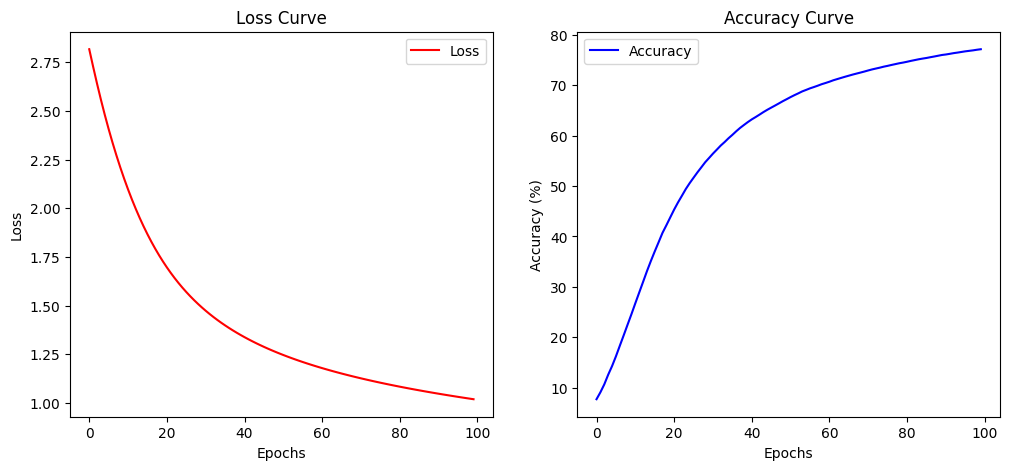

Test Accuracy: 78.58%

Plotting activation histograms for hidden layers:


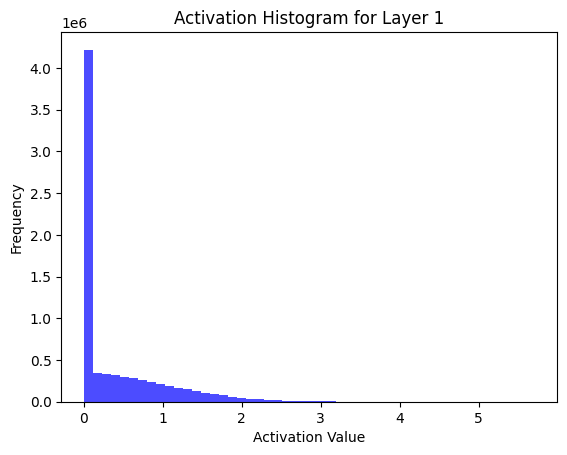

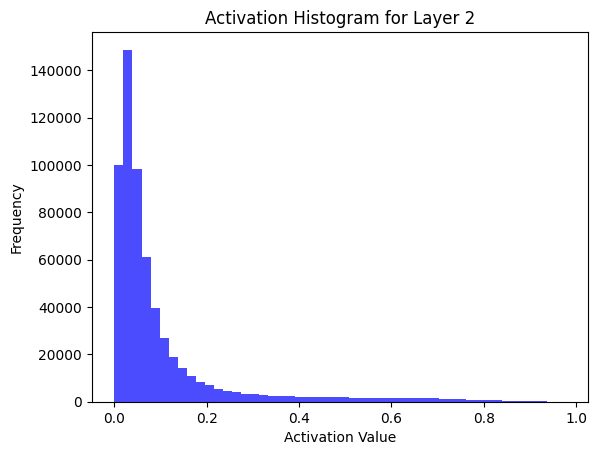

Training network with 5 layers...
Epoch 0, Loss: 2.7453, Accuracy: 8.80%
Epoch 10, Loss: 2.1458, Accuracy: 24.54%
Epoch 20, Loss: 1.7867, Accuracy: 40.39%
Epoch 30, Loss: 1.5691, Accuracy: 51.62%
Epoch 40, Loss: 1.4252, Accuracy: 59.00%
Epoch 50, Loss: 1.3224, Accuracy: 64.12%
Epoch 60, Loss: 1.2443, Accuracy: 67.97%
Epoch 70, Loss: 1.1823, Accuracy: 70.86%
Epoch 80, Loss: 1.1313, Accuracy: 73.14%
Epoch 90, Loss: 1.0881, Accuracy: 74.94%


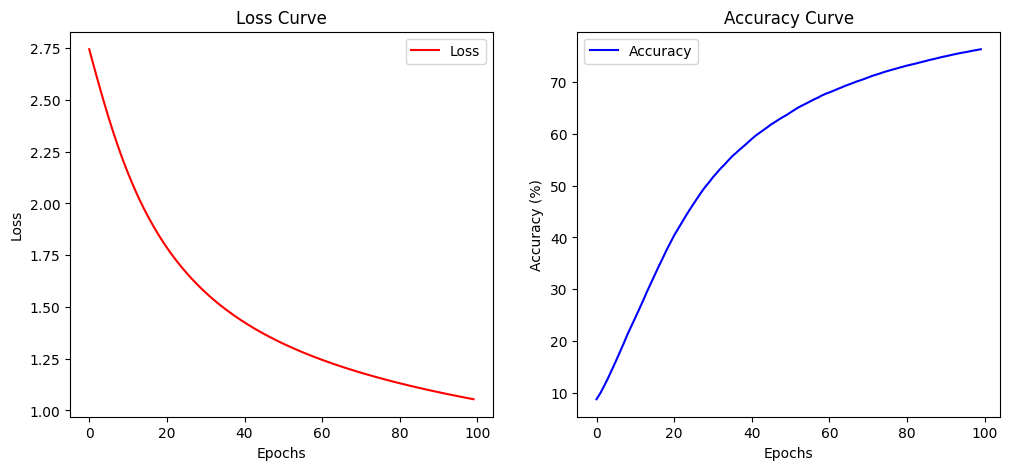

Test Accuracy: 77.31%

Plotting activation histograms for hidden layers:


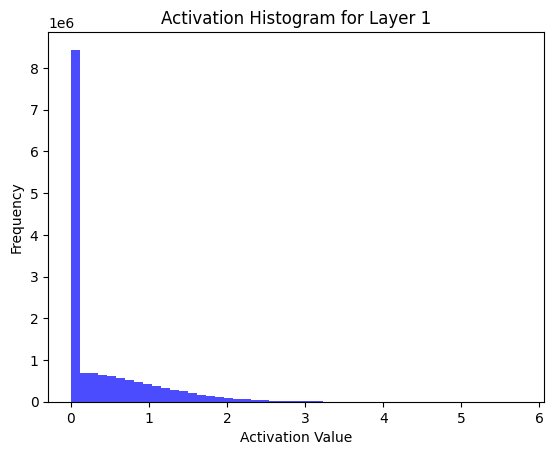

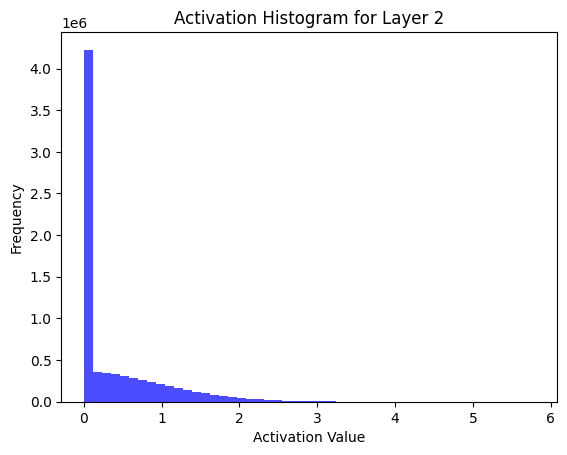

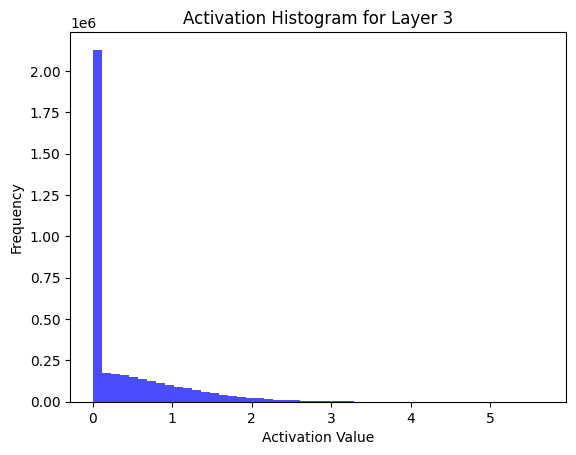

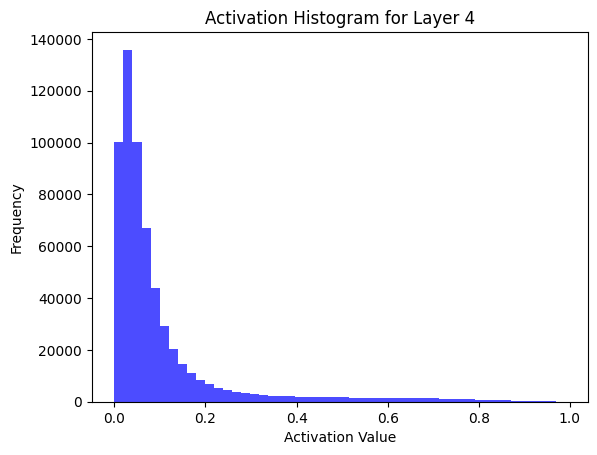

Training network with 7 layers...
Epoch 0, Loss: 2.7436, Accuracy: 9.08%
Epoch 10, Loss: 2.2476, Accuracy: 19.66%
Epoch 20, Loss: 1.9322, Accuracy: 32.45%
Epoch 30, Loss: 1.7358, Accuracy: 42.53%
Epoch 40, Loss: 1.6054, Accuracy: 50.22%
Epoch 50, Loss: 1.5105, Accuracy: 55.95%
Epoch 60, Loss: 1.4370, Accuracy: 60.17%
Epoch 70, Loss: 1.3774, Accuracy: 63.38%
Epoch 80, Loss: 1.3273, Accuracy: 66.02%
Epoch 90, Loss: 1.2835, Accuracy: 68.22%


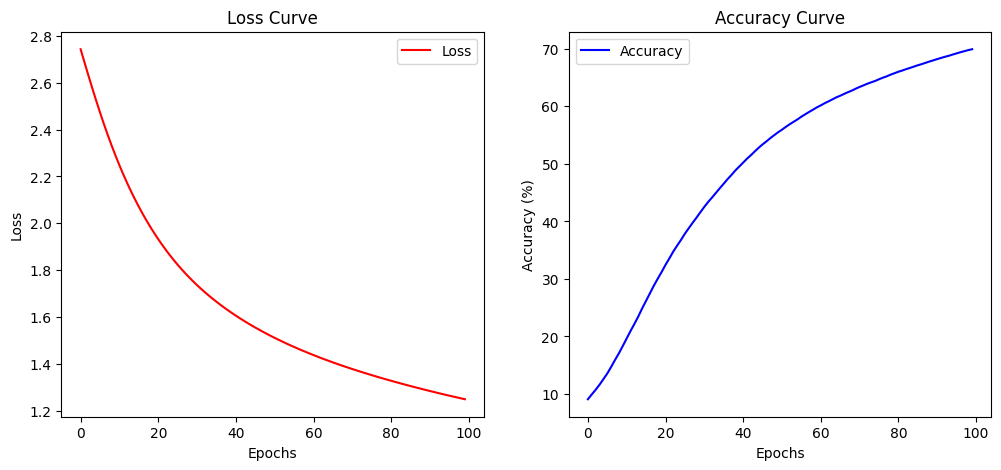

Test Accuracy: 70.32%

Plotting activation histograms for hidden layers:


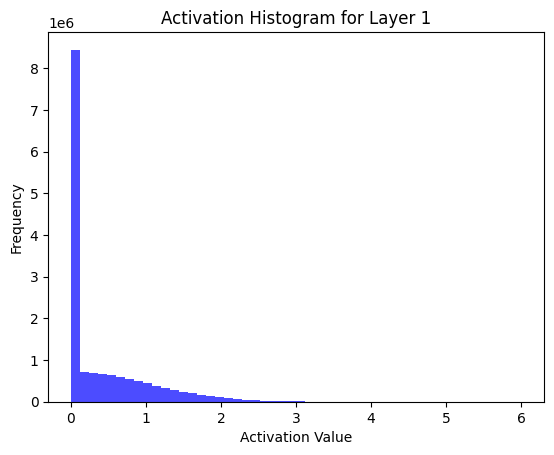

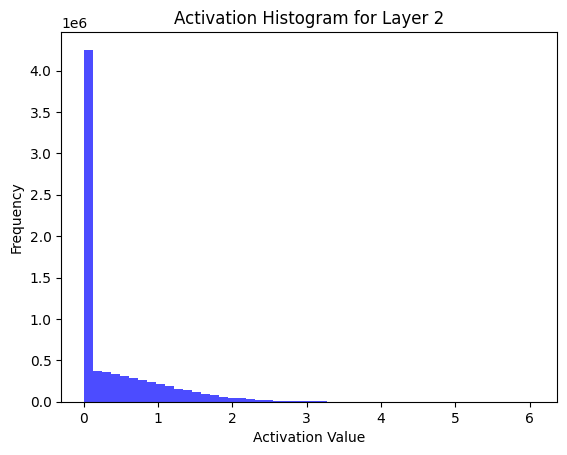

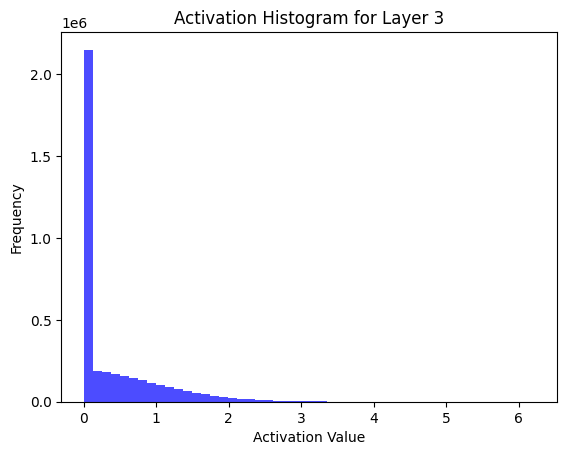

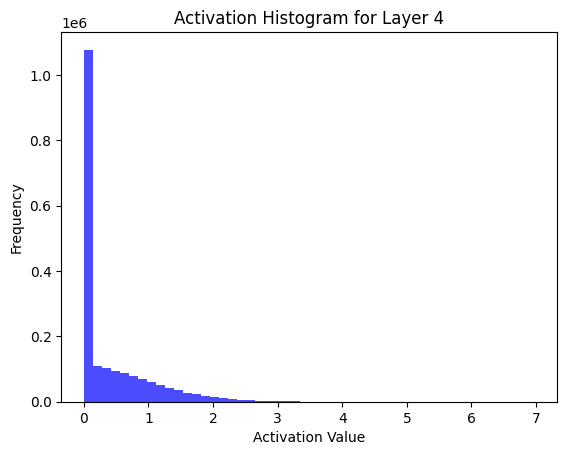

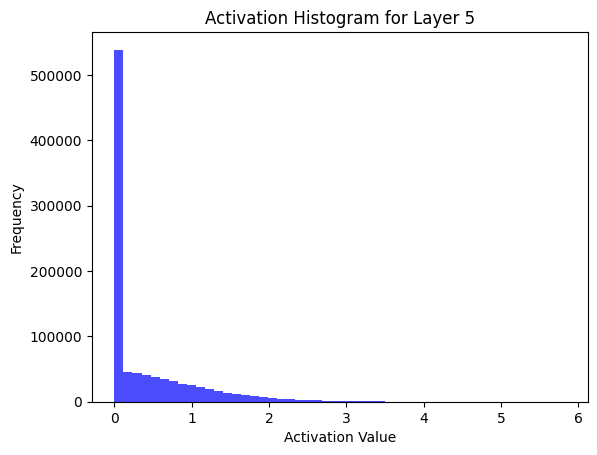

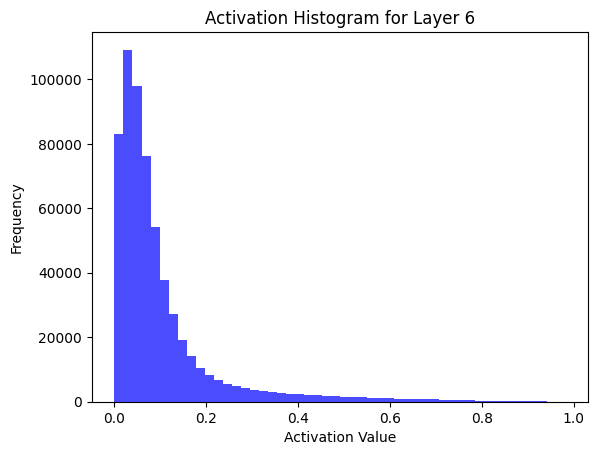

Training network with 10 layers...
Epoch 0, Loss: 2.6115, Accuracy: 11.64%
Epoch 10, Loss: 2.2957, Accuracy: 19.30%
Epoch 20, Loss: 2.1047, Accuracy: 25.52%
Epoch 30, Loss: 1.9795, Accuracy: 30.42%
Epoch 40, Loss: 1.8863, Accuracy: 34.80%
Epoch 50, Loss: 1.8107, Accuracy: 38.58%
Epoch 60, Loss: 1.7450, Accuracy: 42.31%
Epoch 70, Loss: 1.6858, Accuracy: 45.71%
Epoch 80, Loss: 1.6315, Accuracy: 48.79%
Epoch 90, Loss: 1.5815, Accuracy: 51.58%


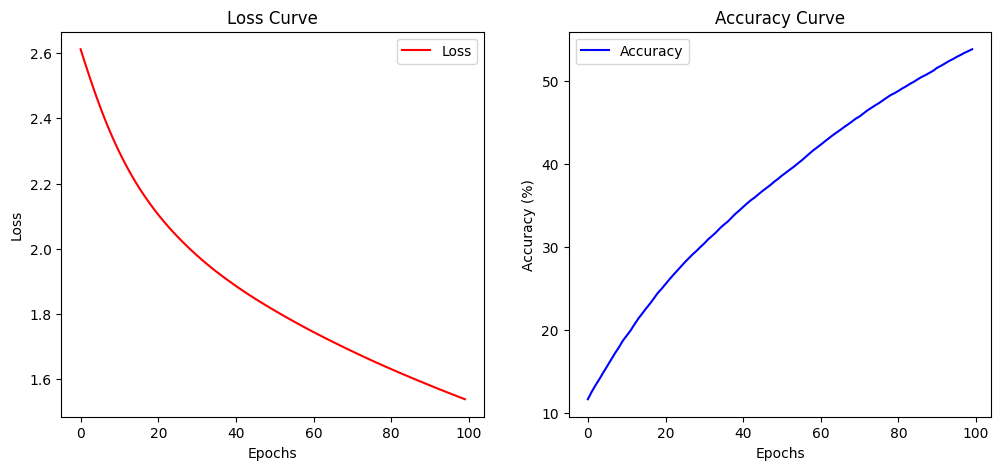

Test Accuracy: 52.55%

Plotting activation histograms for hidden layers:


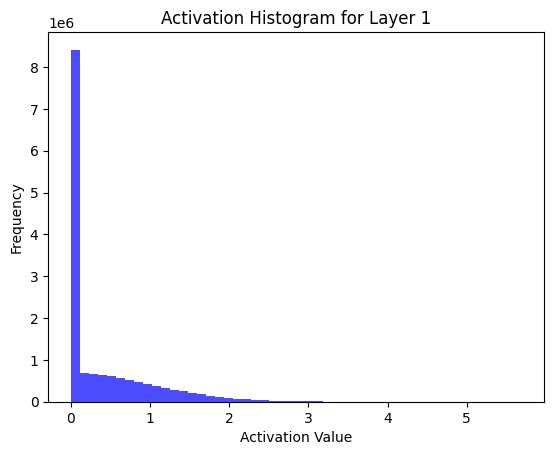

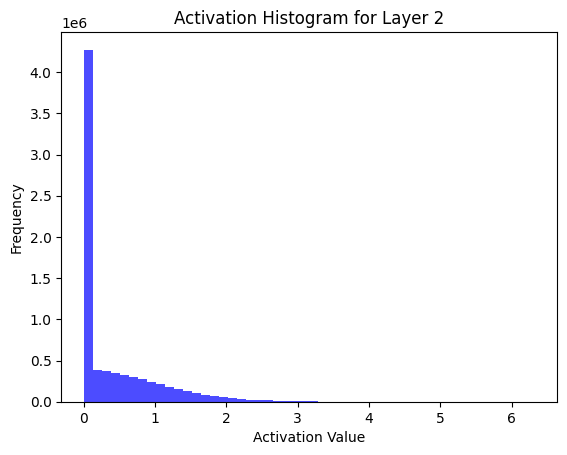

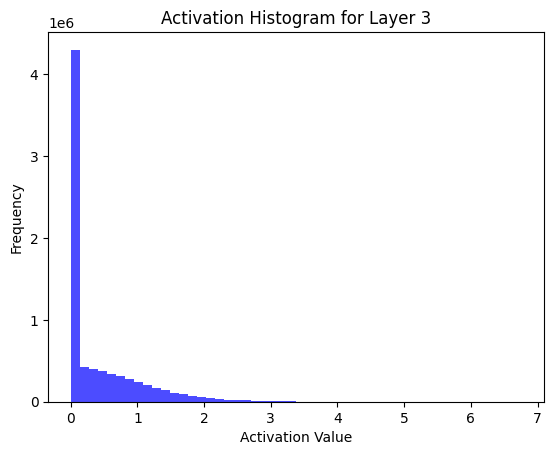

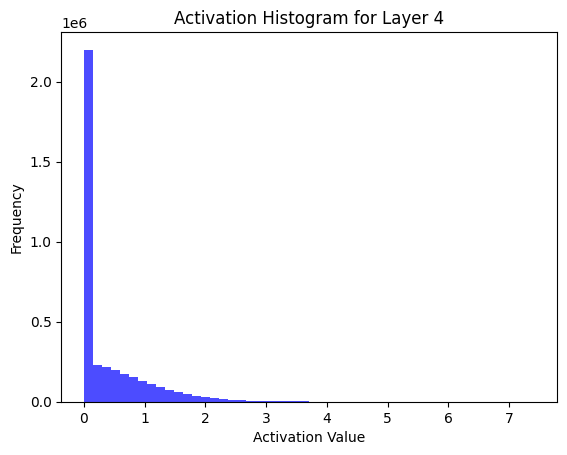

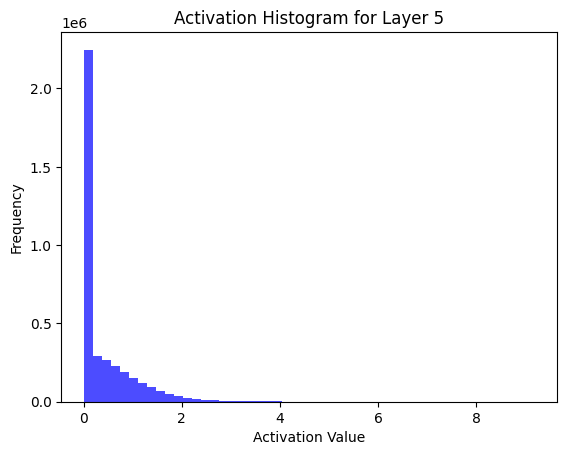

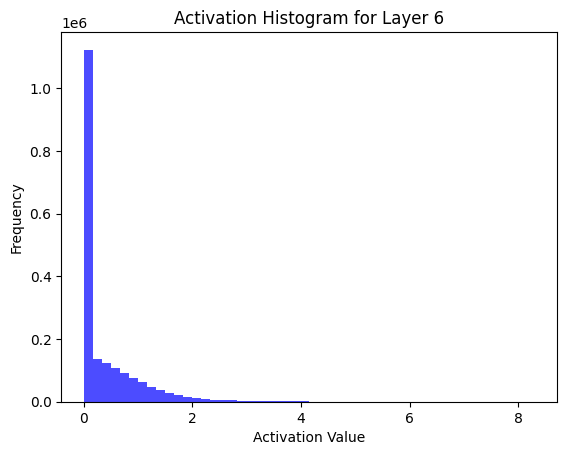

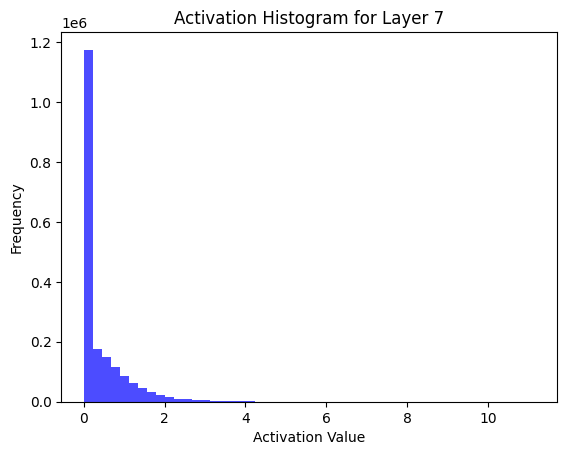

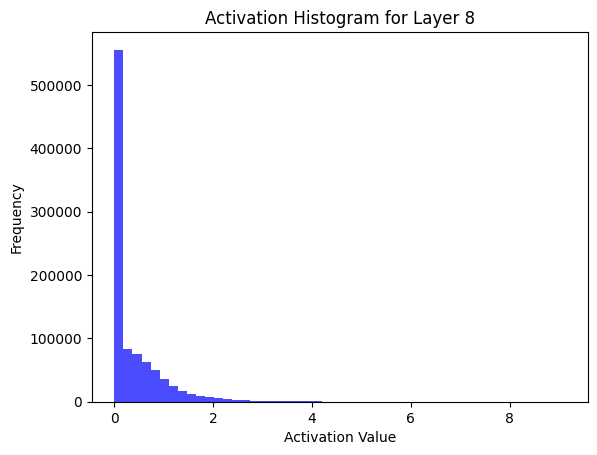

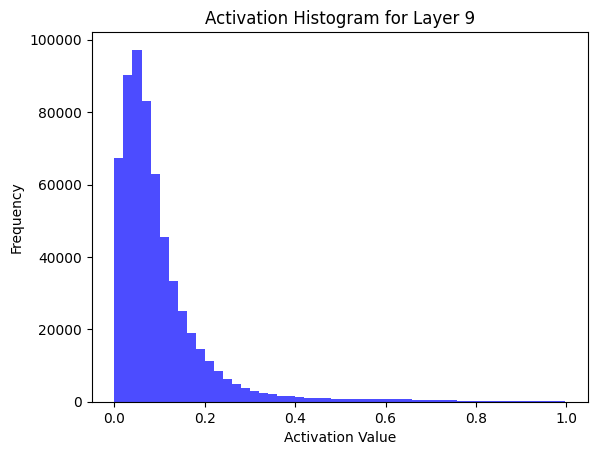

In [24]:
# Train and evaluate each network configuration
loss_histories = []
accuracies = []
gradient_magnitudes_histories = []
parameters=[]

for layer_sizes, activations in network_configs:
    print(f"Training network with {len(layer_sizes)} layers...")
    loss_history, accuracy, gradient_magnitudes_history = train_and_evaluate_network(X_train, y_train, X_test, y_test, layer_sizes, activations, num_epochs=100, learning_rate=0.01)
    loss_histories.append(loss_history)
    accuracies.append(accuracy)
    gradient_magnitudes_histories.append(gradient_magnitudes_history)

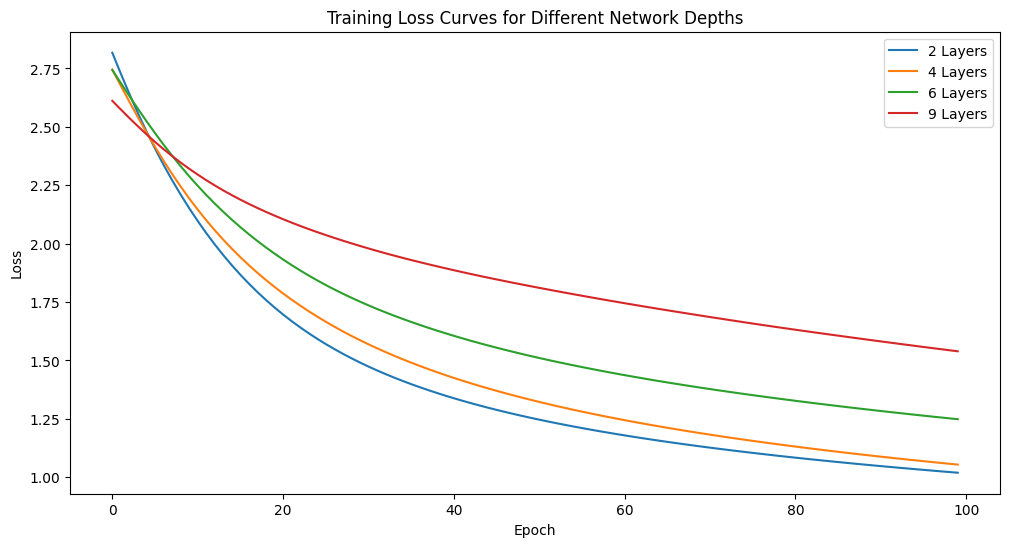

In [25]:
# Plot training loss curves for networks of different depths
plt.figure(figsize=(12, 6))
for i, loss_history in enumerate(loss_histories):
    plt.plot(loss_history, label=f'{len(network_configs[i][0]) - 1} Layers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves for Different Network Depths')
plt.legend()
plt.show()

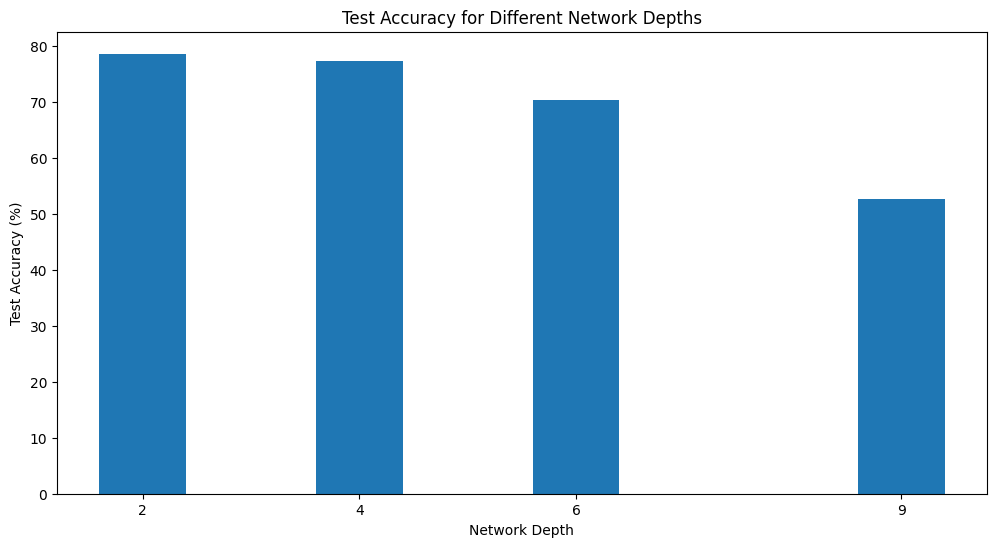

In [26]:
# Plot test accuracy for each network depth
plt.figure(figsize=(12, 6))
depths = [len(config[0]) - 1 for config in network_configs]
plt.bar(depths, accuracies)
plt.xlabel('Network Depth')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy for Different Network Depths')
plt.xticks(depths)
plt.show()

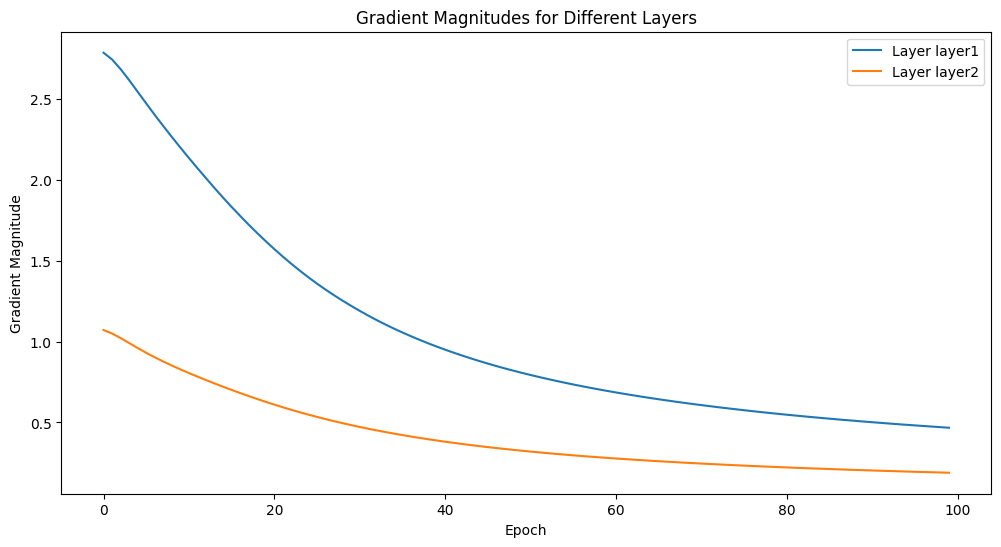

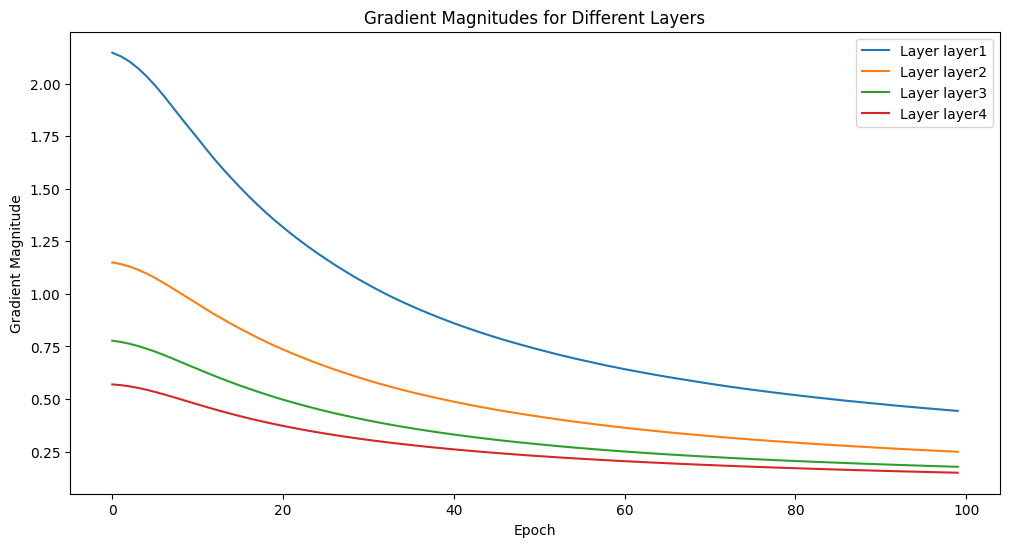

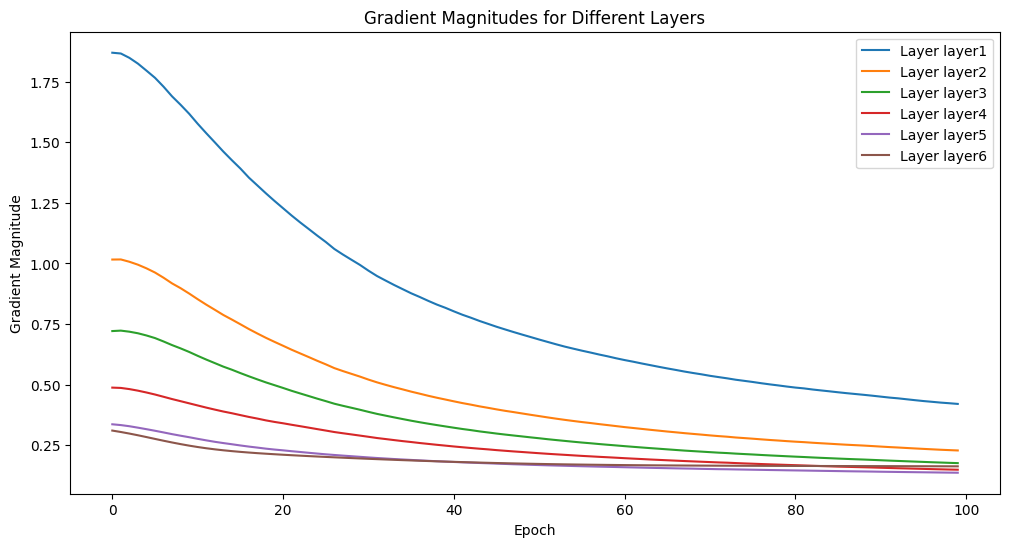

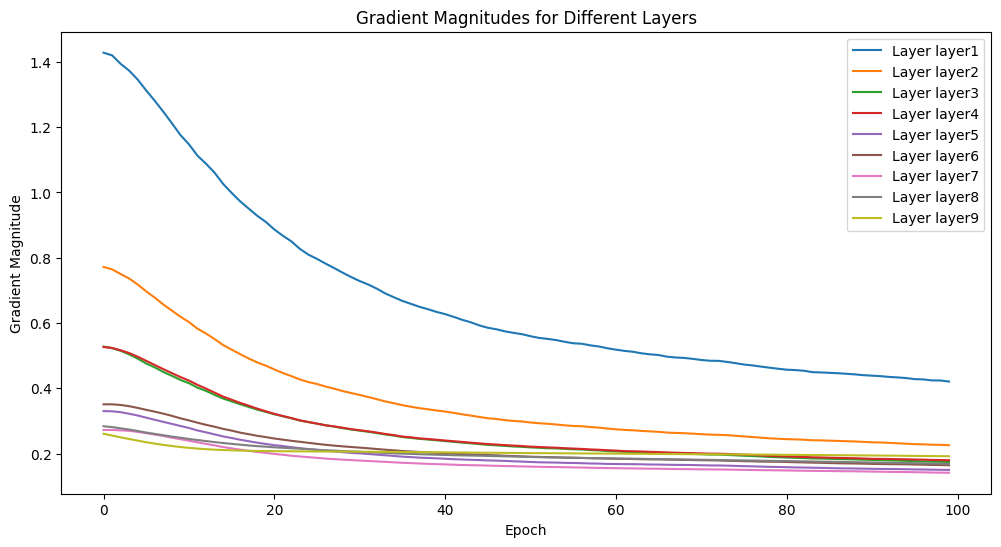

In [27]:
# Plot gradient magnitudes for different layers
plot_gradient_magnitudes(gradient_magnitudes_histories[0])  # Index 0 corresponds to the 3-layer network
plot_gradient_magnitudes(gradient_magnitudes_histories[1])  # Index 1 corresponds to the 5-layer network
plot_gradient_magnitudes(gradient_magnitudes_histories[2])  # Index 2 corresponds to the 7-layer network
plot_gradient_magnitudes(gradient_magnitudes_histories[3])  # Index 3 corresponds to the 10-layer network

For Sigmoid activation

Training network with 3 layers...
Epoch 0, Loss: 2.6853, Accuracy: 9.75%
Epoch 10, Loss: 1.8901, Accuracy: 37.66%
Epoch 20, Loss: 1.5310, Accuracy: 54.17%
Epoch 30, Loss: 1.3506, Accuracy: 62.96%
Epoch 40, Loss: 1.2427, Accuracy: 67.97%
Epoch 50, Loss: 1.1702, Accuracy: 71.23%
Epoch 60, Loss: 1.1174, Accuracy: 73.74%
Epoch 70, Loss: 1.0767, Accuracy: 75.62%
Epoch 80, Loss: 1.0439, Accuracy: 77.07%
Epoch 90, Loss: 1.0166, Accuracy: 78.31%


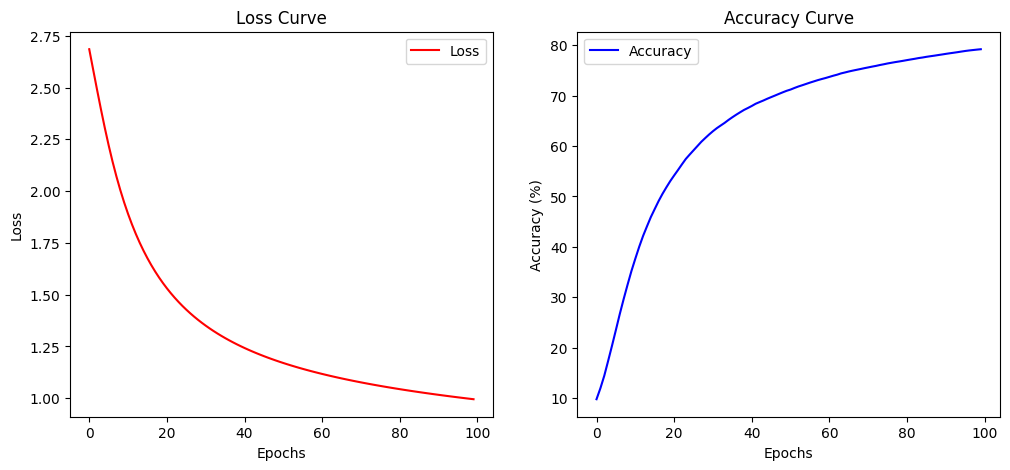

Test Accuracy: 80.41%

Plotting activation histograms for hidden layers:


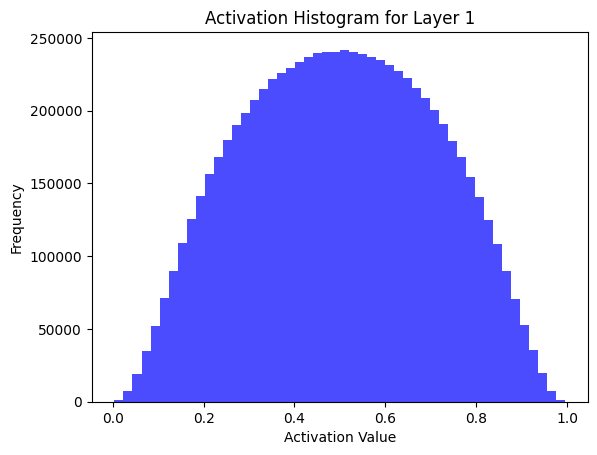

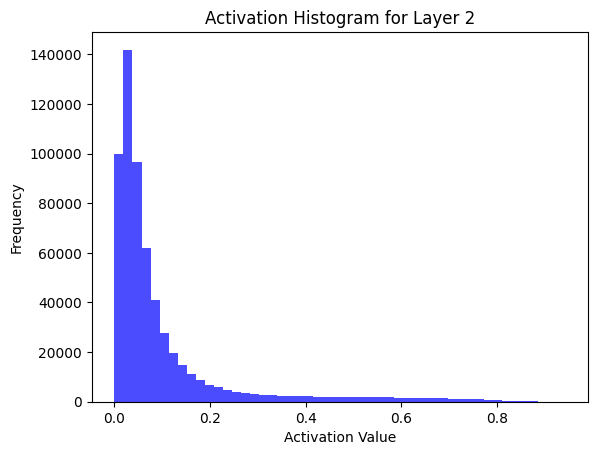

Training network with 5 layers...
Epoch 0, Loss: 2.7544, Accuracy: 10.17%
Epoch 10, Loss: 1.8688, Accuracy: 38.55%
Epoch 20, Loss: 1.5249, Accuracy: 53.95%
Epoch 30, Loss: 1.3522, Accuracy: 62.78%
Epoch 40, Loss: 1.2435, Accuracy: 68.37%
Epoch 50, Loss: 1.1669, Accuracy: 72.14%
Epoch 60, Loss: 1.1095, Accuracy: 74.67%
Epoch 70, Loss: 1.0647, Accuracy: 76.60%
Epoch 80, Loss: 1.0287, Accuracy: 78.05%
Epoch 90, Loss: 0.9988, Accuracy: 79.09%


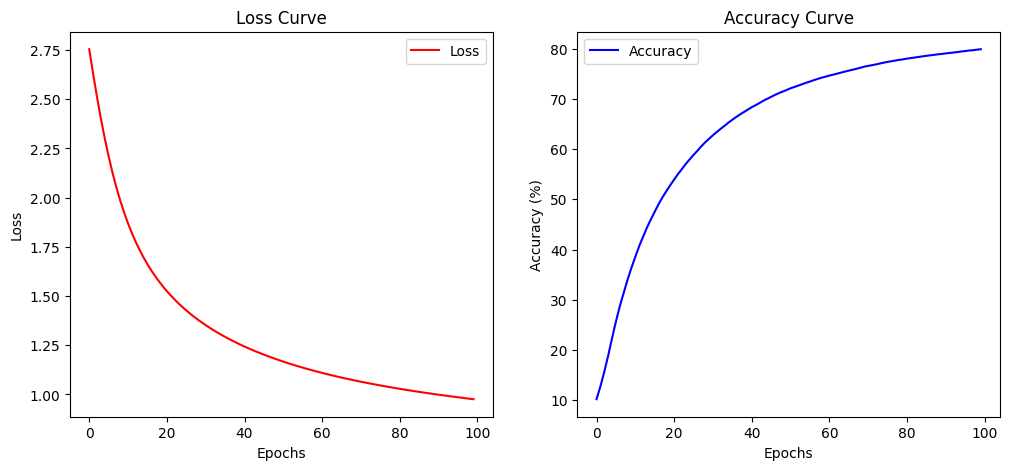

Test Accuracy: 81.41%

Plotting activation histograms for hidden layers:


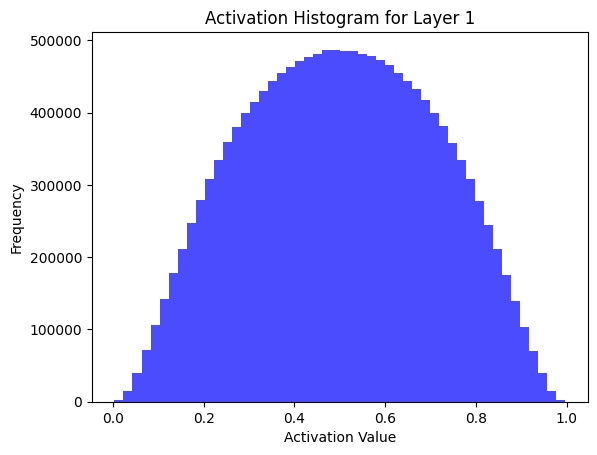

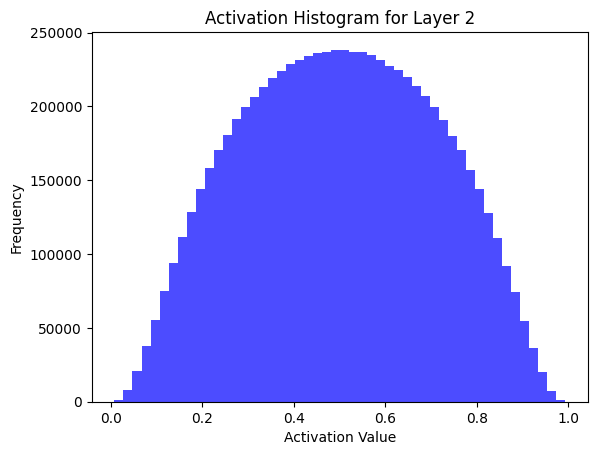

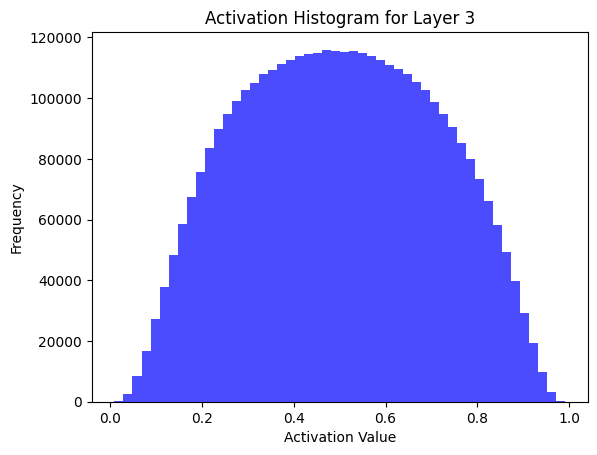

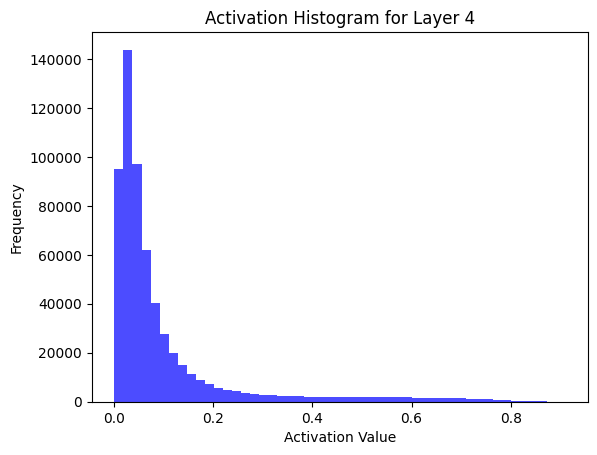

Training network with 7 layers...
Epoch 0, Loss: 2.6483, Accuracy: 10.58%
Epoch 10, Loss: 1.8478, Accuracy: 36.73%
Epoch 20, Loss: 1.5568, Accuracy: 51.71%
Epoch 30, Loss: 1.4068, Accuracy: 60.22%
Epoch 40, Loss: 1.3106, Accuracy: 65.75%
Epoch 50, Loss: 1.2411, Accuracy: 69.42%
Epoch 60, Loss: 1.1868, Accuracy: 72.10%
Epoch 70, Loss: 1.1422, Accuracy: 74.26%
Epoch 80, Loss: 1.1045, Accuracy: 75.91%
Epoch 90, Loss: 1.0717, Accuracy: 77.22%


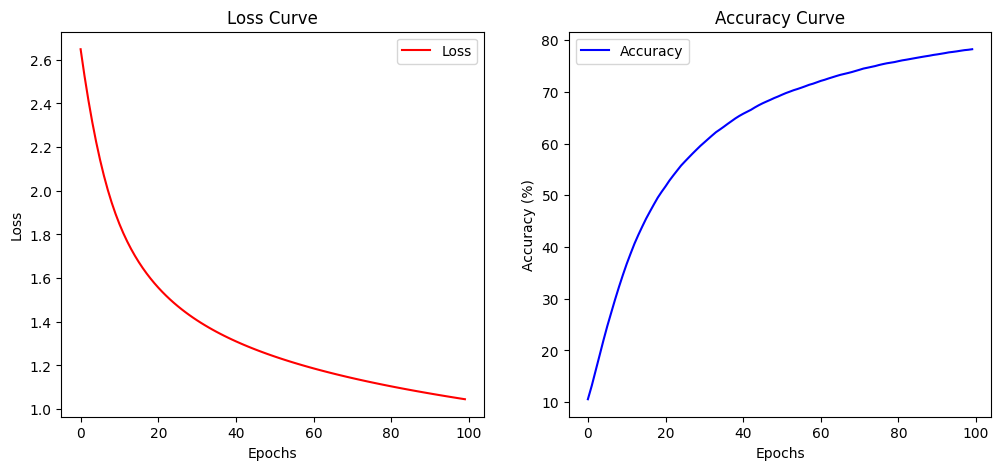

Test Accuracy: 78.63%

Plotting activation histograms for hidden layers:


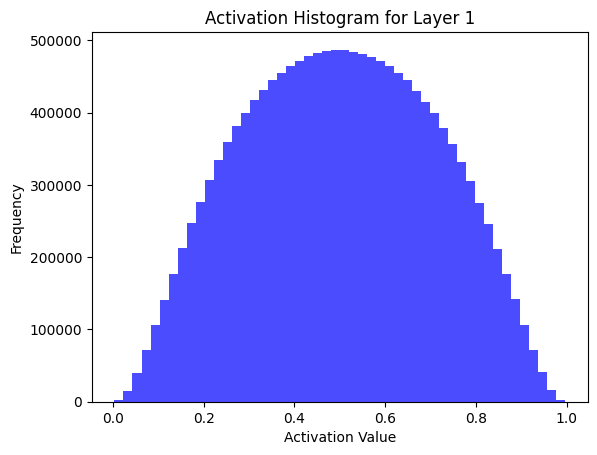

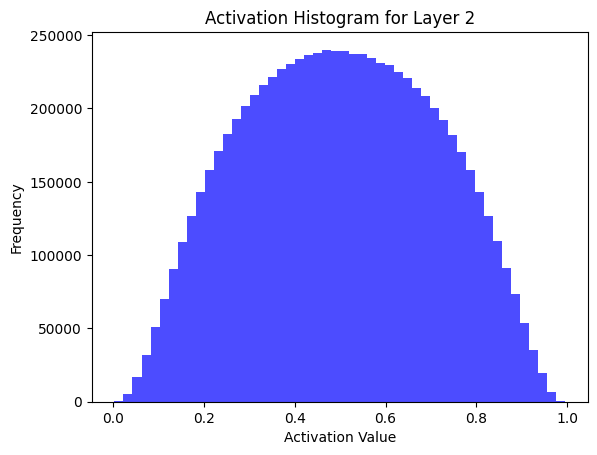

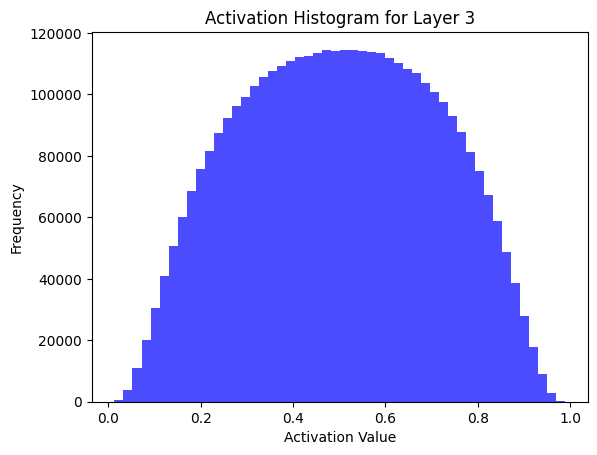

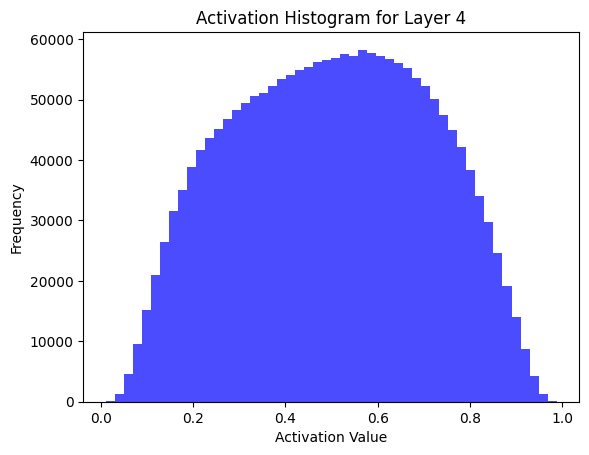

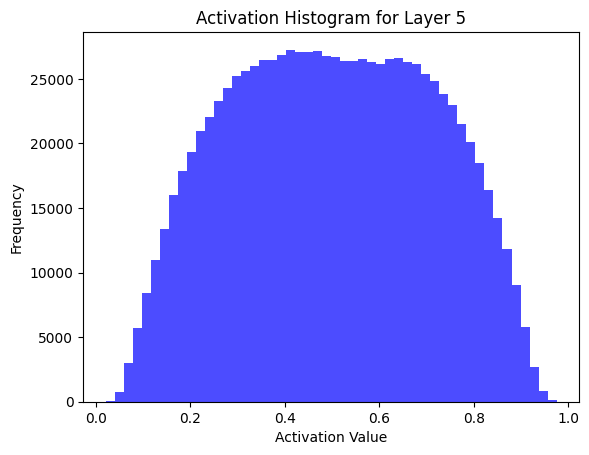

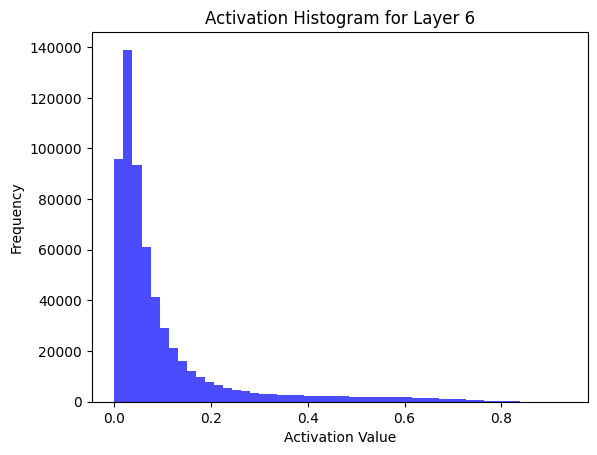

Training network with 10 layers...
Epoch 0, Loss: 2.8220, Accuracy: 6.78%
Epoch 10, Loss: 1.7505, Accuracy: 39.95%
Epoch 20, Loss: 1.4853, Accuracy: 52.48%
Epoch 30, Loss: 1.3564, Accuracy: 59.76%
Epoch 40, Loss: 1.2746, Accuracy: 64.38%
Epoch 50, Loss: 1.2147, Accuracy: 67.80%
Epoch 60, Loss: 1.1670, Accuracy: 70.40%
Epoch 70, Loss: 1.1269, Accuracy: 72.41%
Epoch 80, Loss: 1.0922, Accuracy: 74.05%
Epoch 90, Loss: 1.0613, Accuracy: 75.40%


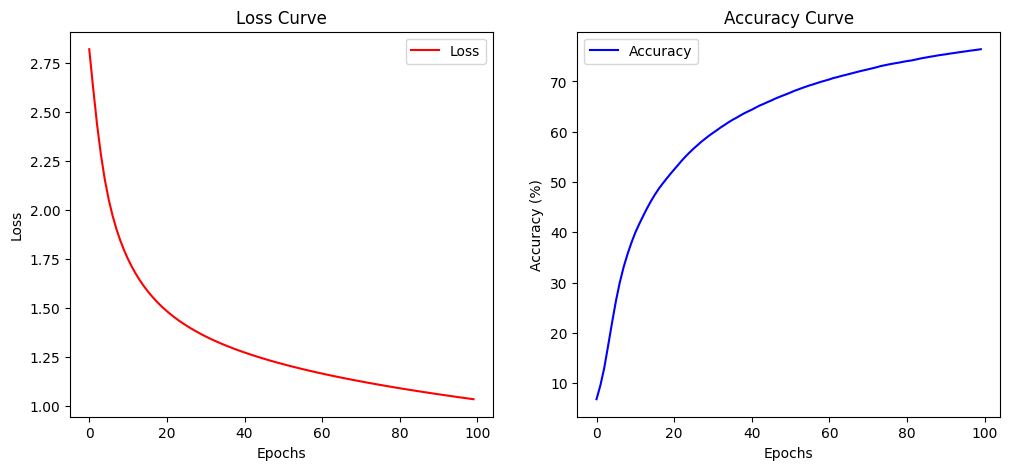

Test Accuracy: 77.72%

Plotting activation histograms for hidden layers:


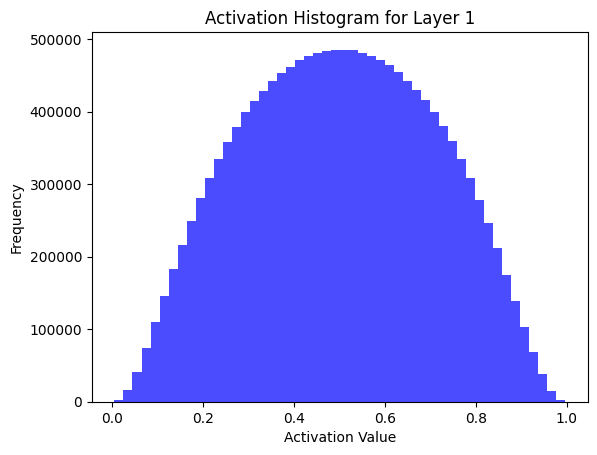

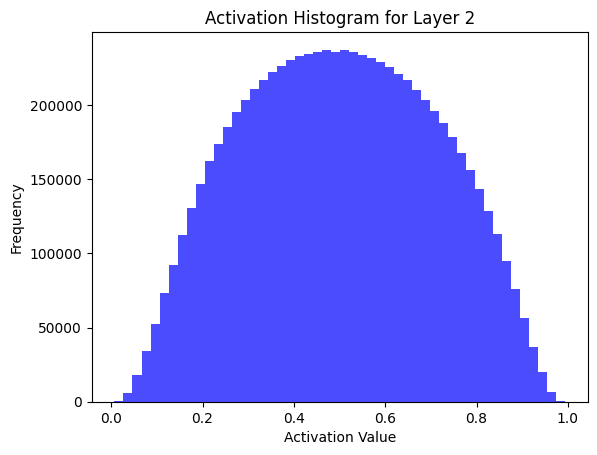

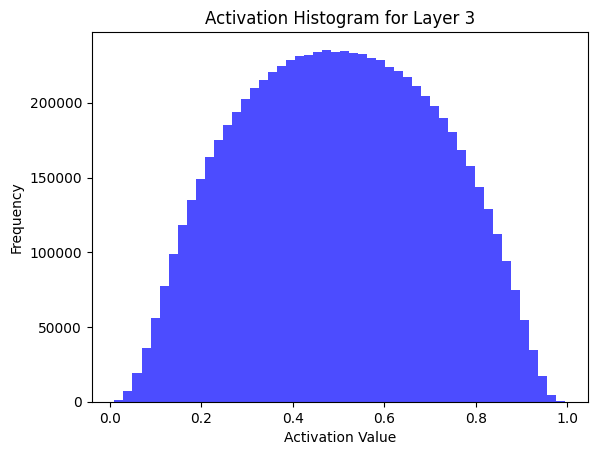

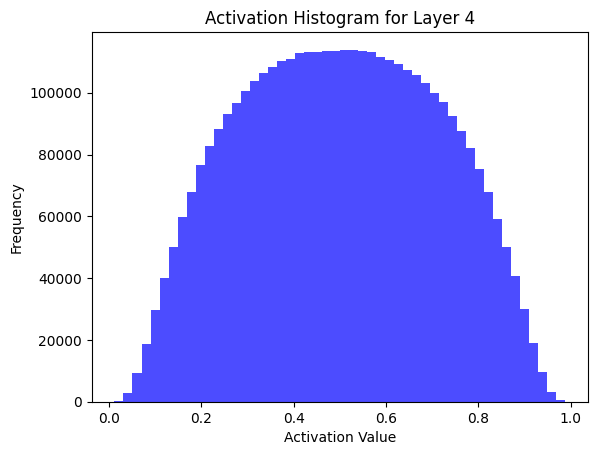

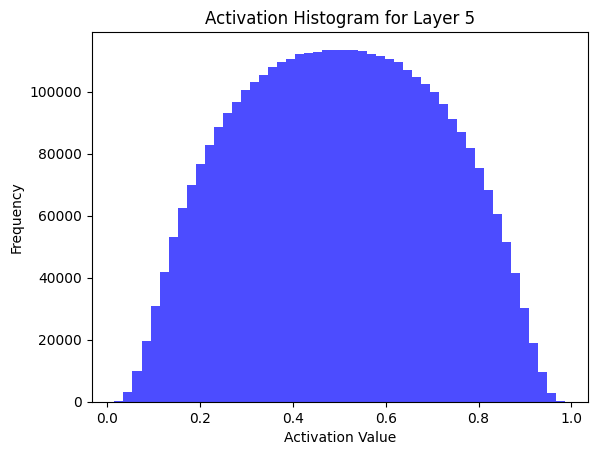

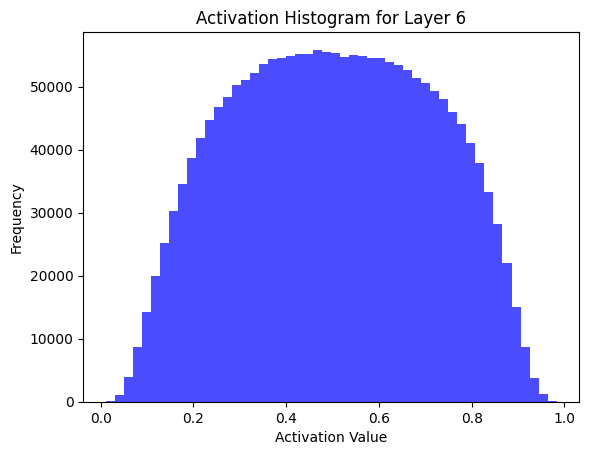

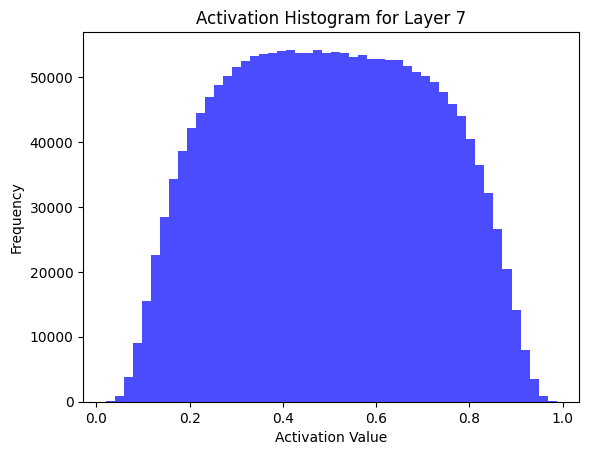

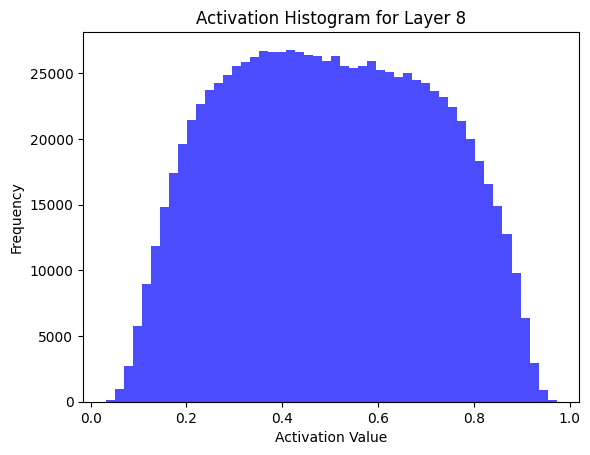

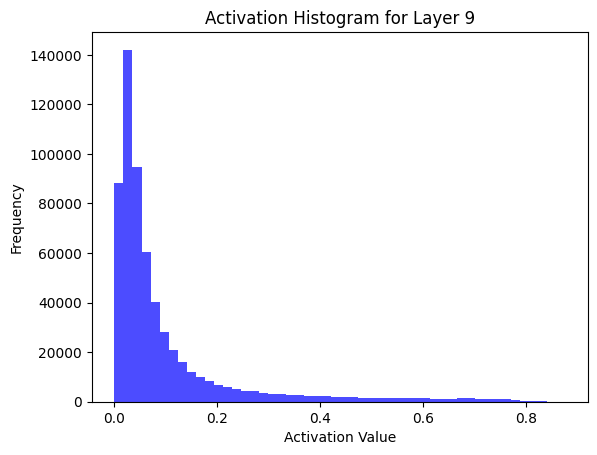

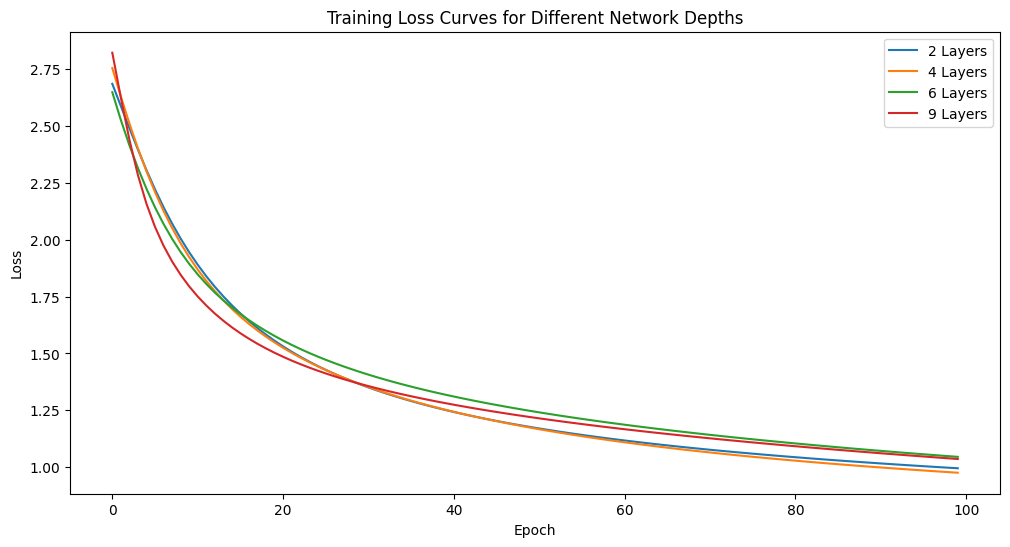

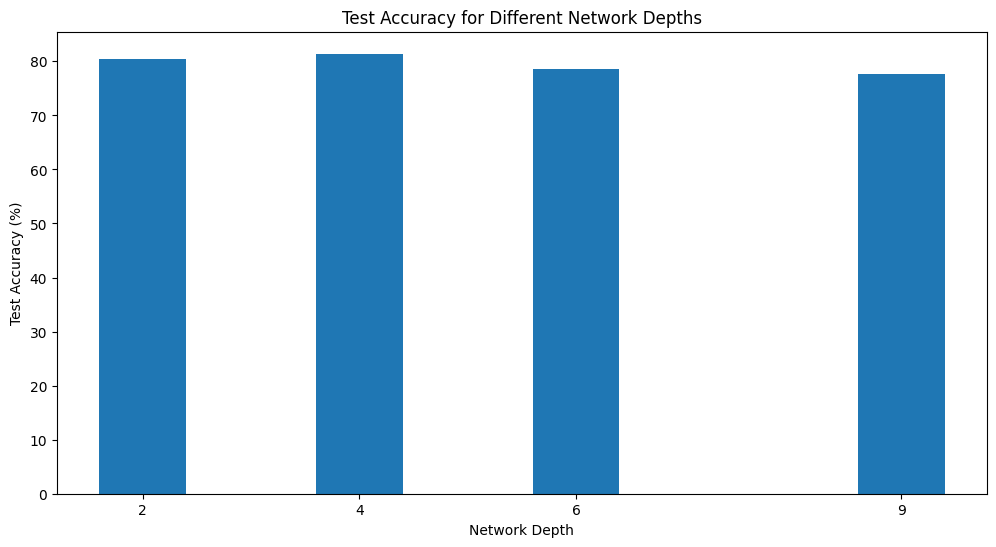

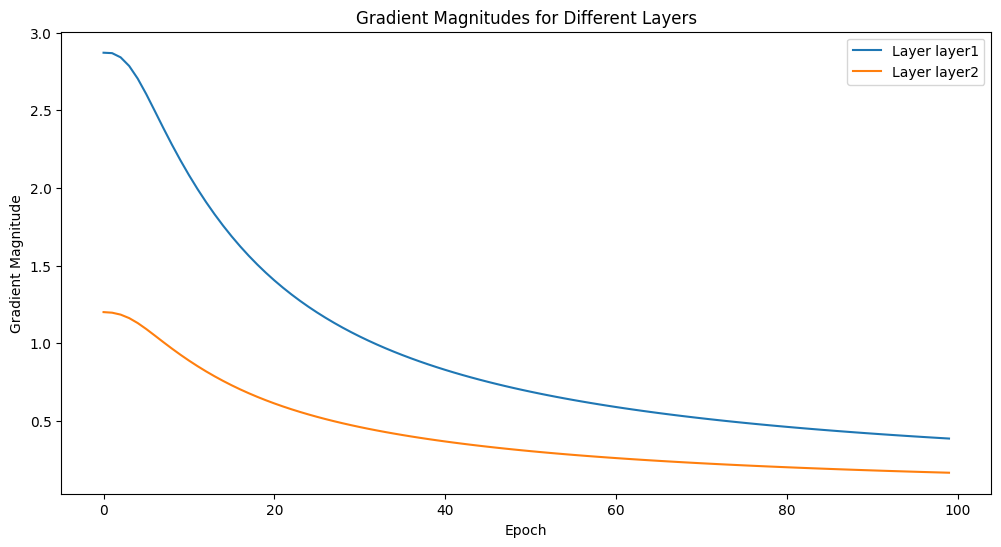

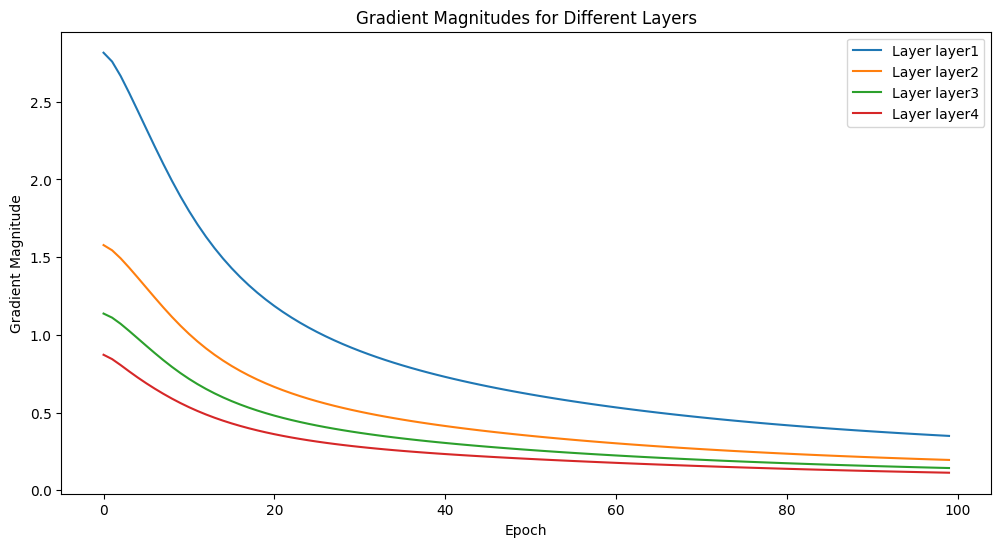

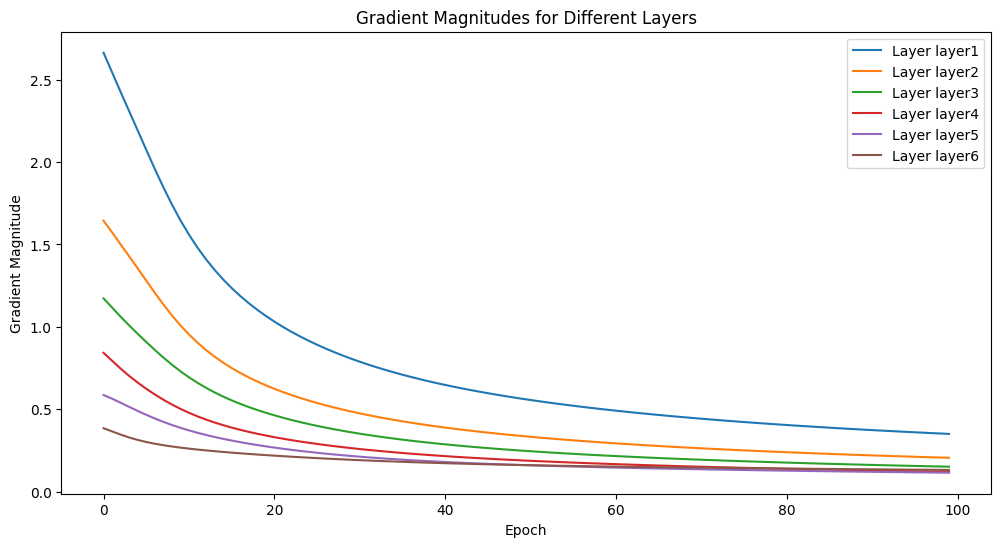

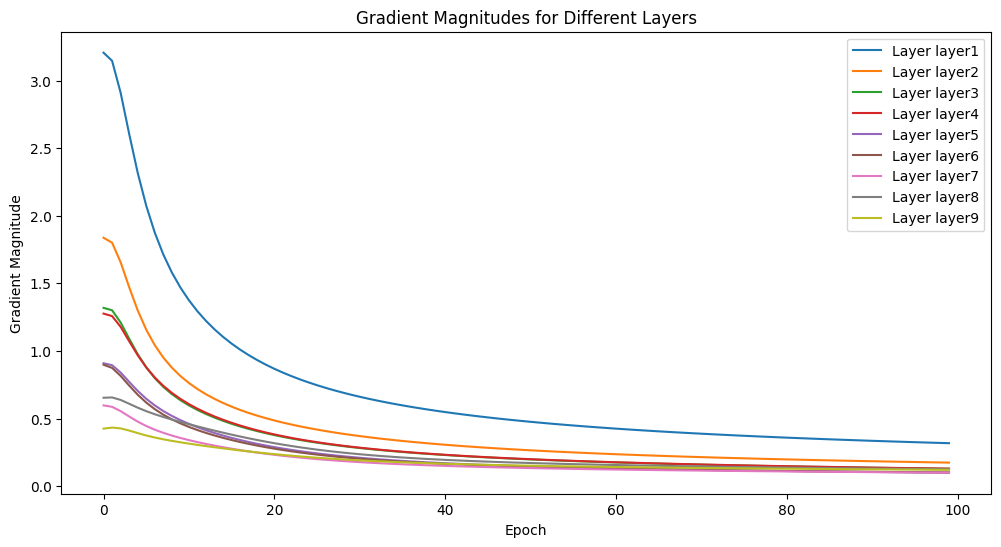

In [29]:
# Define network configurations for 3, 5, 7, and 10 layers
network_configs = [
    # 3-layer network
    ([784, 128, 10], ["sigmoid", "softmax"]),
    # 5-layer network
    ([784, 256, 128, 64, 10], ["sigmoid", "sigmoid", "sigmoid", "softmax"]),
    # 7-layer network
    ([784, 256, 128, 64, 32, 16, 10], ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"]),
    # 10-layer network
    ([784, 256, 128, 128, 64, 64, 32, 32, 16, 10], ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"])
]

# Train and evaluate each network configuration
loss_histories = []
accuracies = []
gradient_magnitudes_histories = []

for layer_sizes, activations in network_configs:
    print(f"Training network with {len(layer_sizes)} layers...")
    loss_history, accuracy, gradient_magnitudes_history = train_and_evaluate_network(X_train, y_train, X_test, y_test, layer_sizes, activations, num_epochs=100, learning_rate=0.01)
    loss_histories.append(loss_history)
    accuracies.append(accuracy)
    gradient_magnitudes_histories.append(gradient_magnitudes_history)

# Plot training loss curves for networks of different depths
plt.figure(figsize=(12, 6))
for i, loss_history in enumerate(loss_histories):
    plt.plot(loss_history, label=f'{len(network_configs[i][0]) - 1} Layers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves for Different Network Depths')
plt.legend()
plt.show()

# Plot test accuracy for each network depth
plt.figure(figsize=(12, 6))
depths = [len(config[0]) - 1 for config in network_configs]
plt.bar(depths, accuracies)
plt.xlabel('Network Depth')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy for Different Network Depths')
plt.xticks(depths)
plt.show()

# Plot gradient magnitudes for different layers
plot_gradient_magnitudes(gradient_magnitudes_histories[0])  # Index 0 corresponds to the 3-layer network
plot_gradient_magnitudes(gradient_magnitudes_histories[1])  # Index 1 corresponds to the 5-layer network
plot_gradient_magnitudes(gradient_magnitudes_histories[2])  # Index 2 corresponds to the 7-layer network
plot_gradient_magnitudes(gradient_magnitudes_histories[3])  # Index 3 corresponds to the 10-layer network

For Tanh activation

Training network with 3 layers...
Epoch 0, Loss: 2.6919, Accuracy: 8.94%
Epoch 10, Loss: 1.7808, Accuracy: 39.40%
Epoch 20, Loss: 1.4408, Accuracy: 57.27%
Epoch 30, Loss: 1.2848, Accuracy: 65.72%
Epoch 40, Loss: 1.1935, Accuracy: 70.46%
Epoch 50, Loss: 1.1318, Accuracy: 73.47%
Epoch 60, Loss: 1.0861, Accuracy: 75.48%
Epoch 70, Loss: 1.0500, Accuracy: 77.02%
Epoch 80, Loss: 1.0204, Accuracy: 78.22%
Epoch 90, Loss: 0.9952, Accuracy: 79.24%


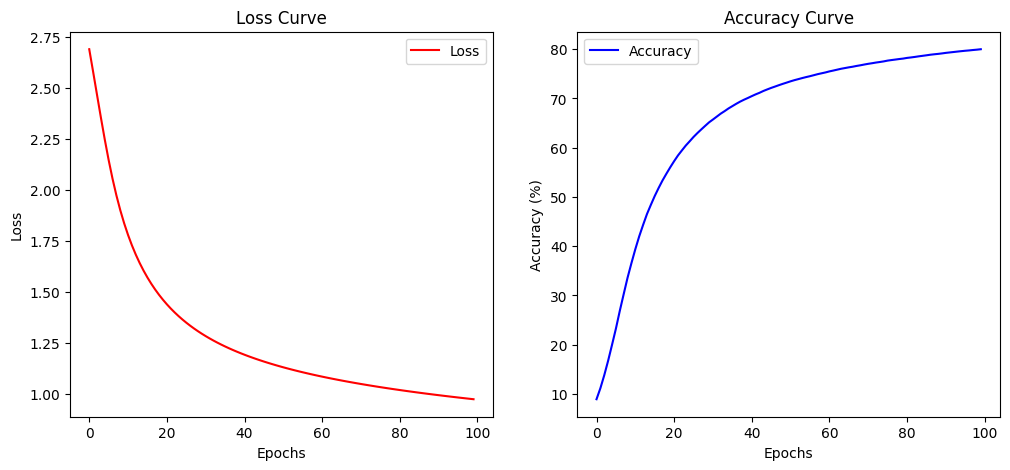

Test Accuracy: 81.44%

Plotting activation histograms for hidden layers:


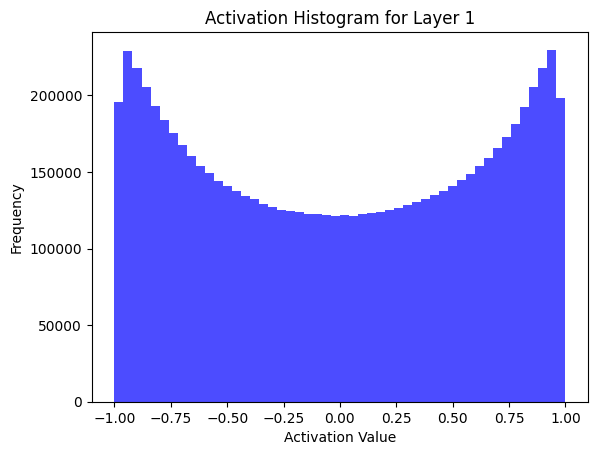

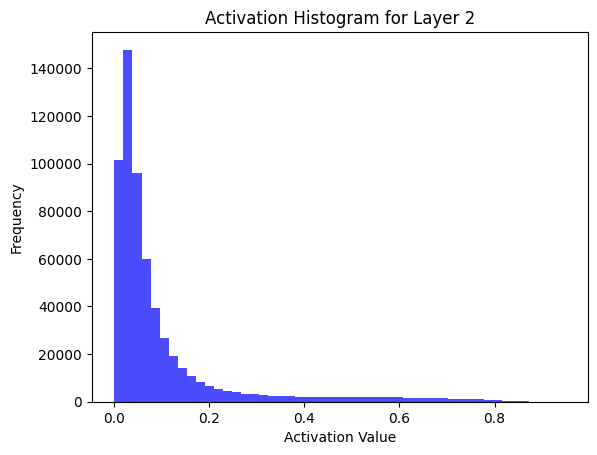

Training network with 5 layers...
Epoch 0, Loss: 2.8689, Accuracy: 7.12%
Epoch 10, Loss: 1.7354, Accuracy: 43.23%
Epoch 20, Loss: 1.3727, Accuracy: 61.43%
Epoch 30, Loss: 1.2175, Accuracy: 69.14%
Epoch 40, Loss: 1.1287, Accuracy: 73.51%
Epoch 50, Loss: 1.0685, Accuracy: 76.34%
Epoch 60, Loss: 1.0235, Accuracy: 78.21%
Epoch 70, Loss: 0.9878, Accuracy: 79.62%
Epoch 80, Loss: 0.9582, Accuracy: 80.60%
Epoch 90, Loss: 0.9330, Accuracy: 81.46%


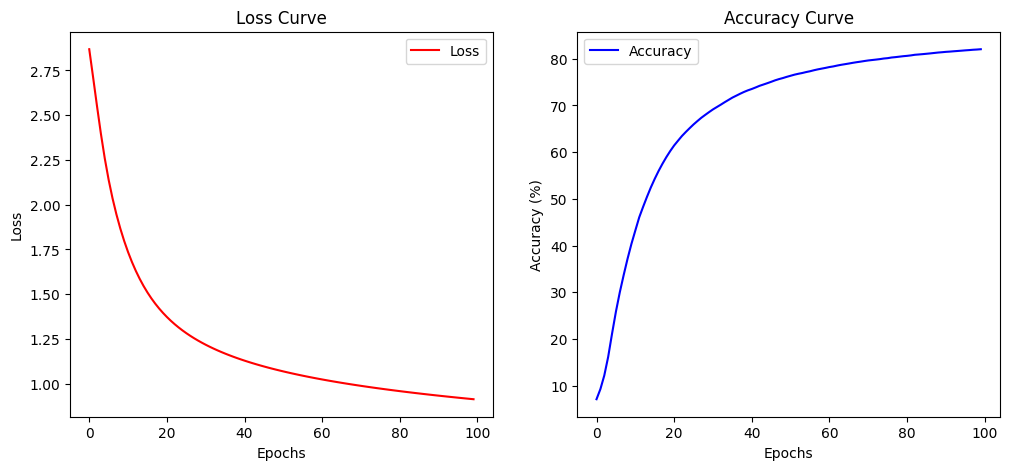

Test Accuracy: 82.97%

Plotting activation histograms for hidden layers:


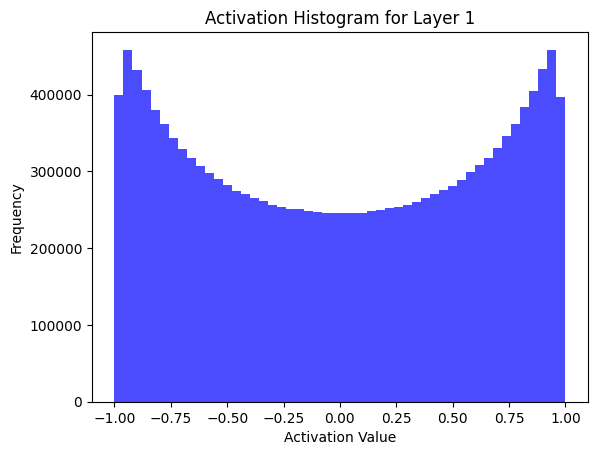

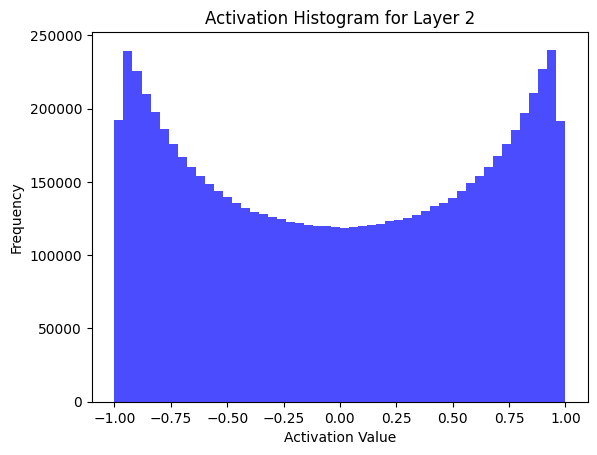

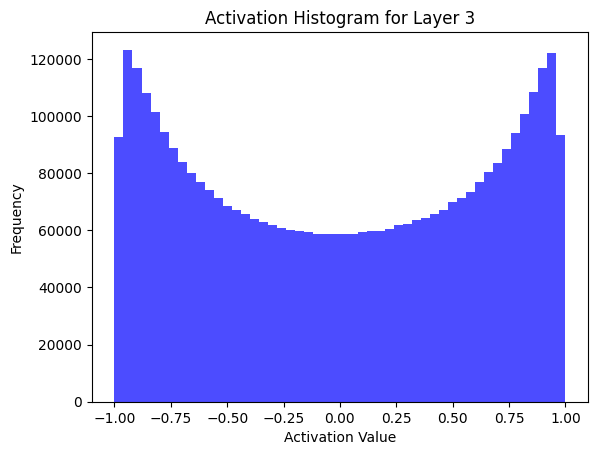

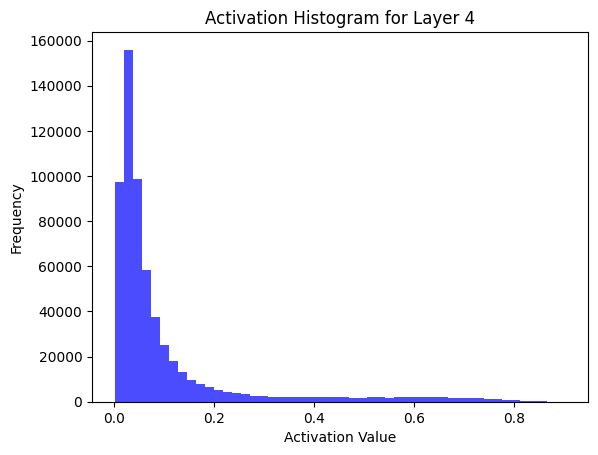

Training network with 7 layers...
Epoch 0, Loss: 2.5955, Accuracy: 11.51%
Epoch 10, Loss: 1.5392, Accuracy: 50.70%
Epoch 20, Loss: 1.3171, Accuracy: 63.71%
Epoch 30, Loss: 1.2099, Accuracy: 69.76%
Epoch 40, Loss: 1.1412, Accuracy: 73.35%
Epoch 50, Loss: 1.0905, Accuracy: 75.87%
Epoch 60, Loss: 1.0500, Accuracy: 77.52%
Epoch 70, Loss: 1.0159, Accuracy: 78.98%
Epoch 80, Loss: 0.9865, Accuracy: 80.03%
Epoch 90, Loss: 0.9605, Accuracy: 80.97%


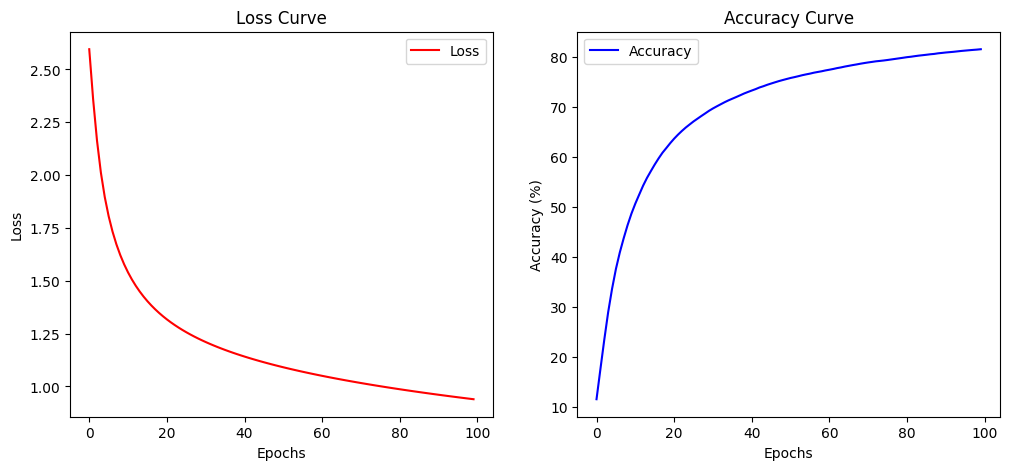

Test Accuracy: 82.51%

Plotting activation histograms for hidden layers:


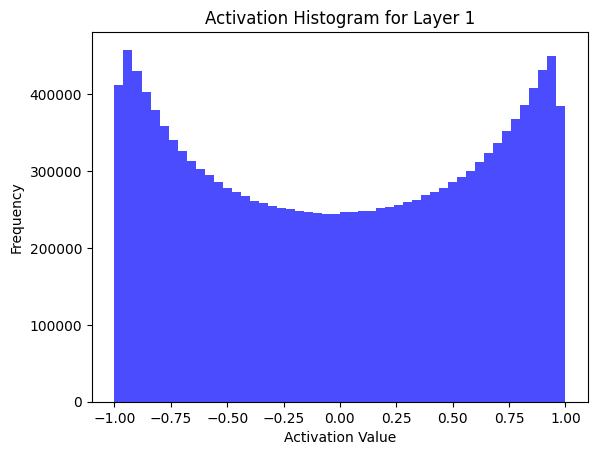

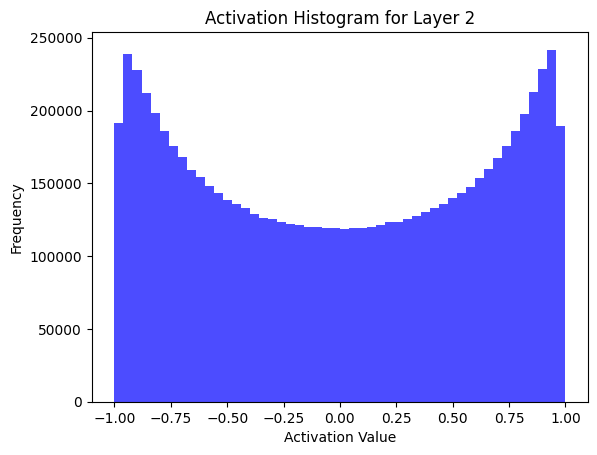

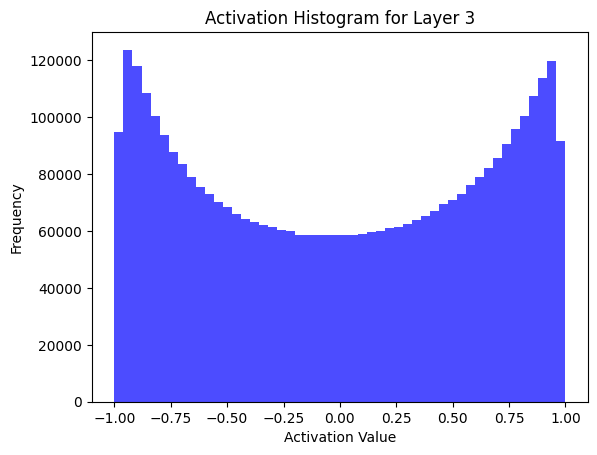

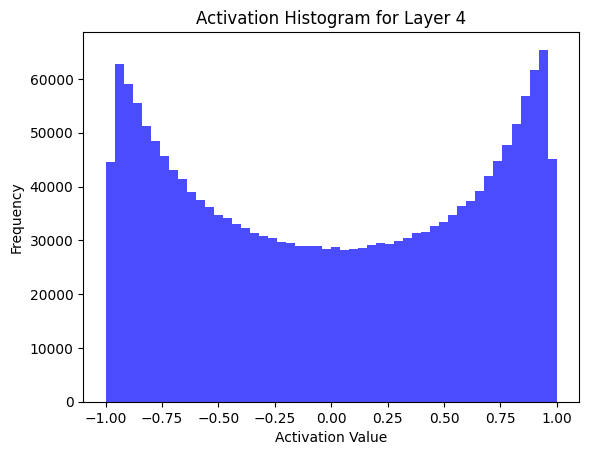

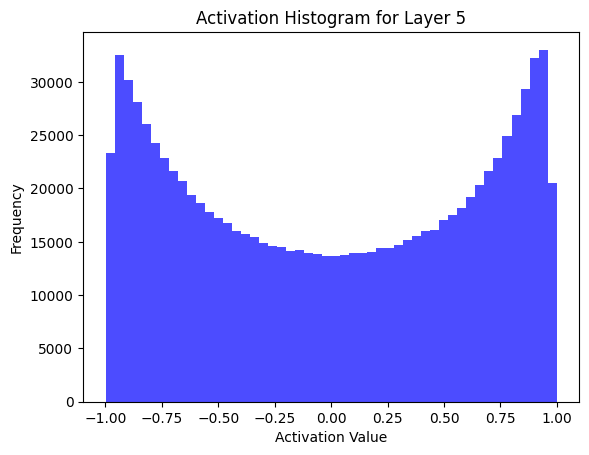

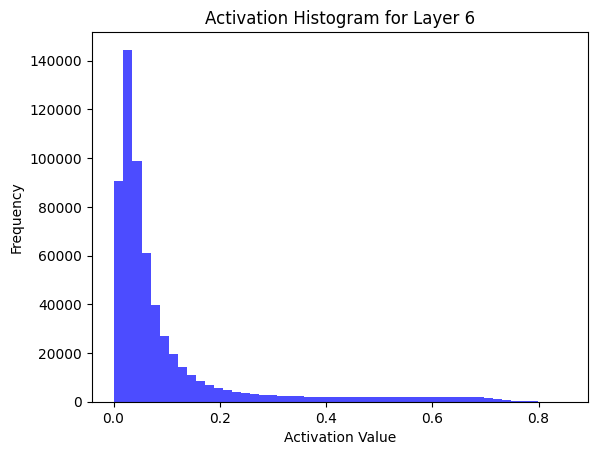

Training network with 10 layers...
Epoch 0, Loss: 2.6110, Accuracy: 11.49%
Epoch 10, Loss: 1.5160, Accuracy: 55.65%
Epoch 20, Loss: 1.3107, Accuracy: 65.82%
Epoch 30, Loss: 1.2040, Accuracy: 70.97%
Epoch 40, Loss: 1.1325, Accuracy: 73.93%
Epoch 50, Loss: 1.0791, Accuracy: 76.19%
Epoch 60, Loss: 1.0362, Accuracy: 77.86%
Epoch 70, Loss: 1.0001, Accuracy: 79.16%
Epoch 80, Loss: 0.9686, Accuracy: 80.20%
Epoch 90, Loss: 0.9406, Accuracy: 81.18%


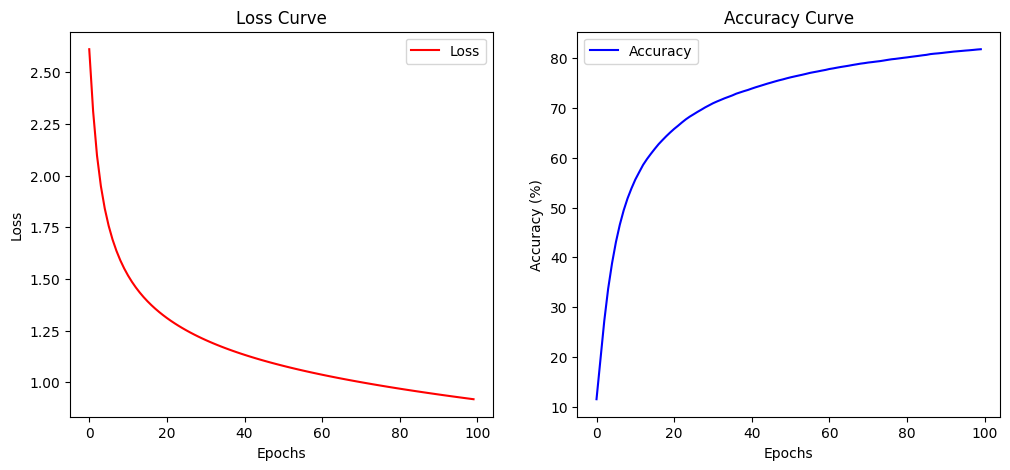

Test Accuracy: 82.83%

Plotting activation histograms for hidden layers:


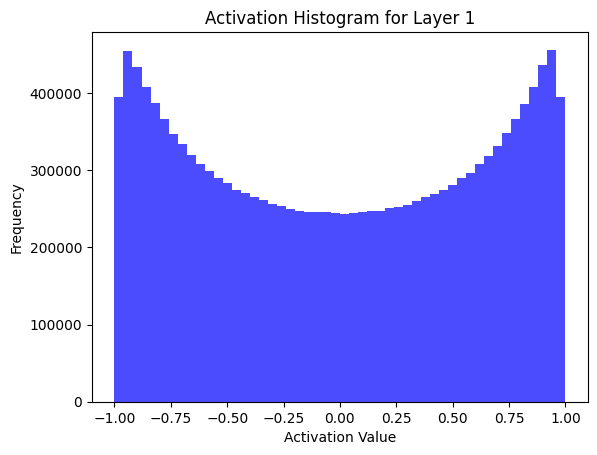

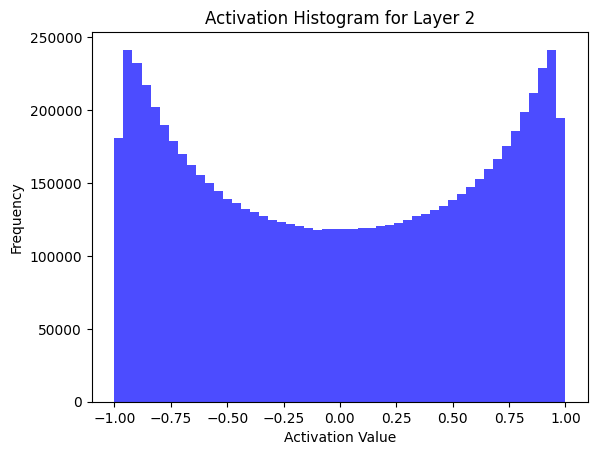

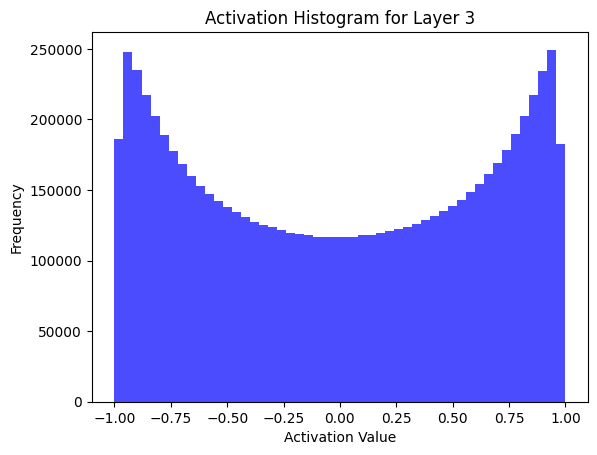

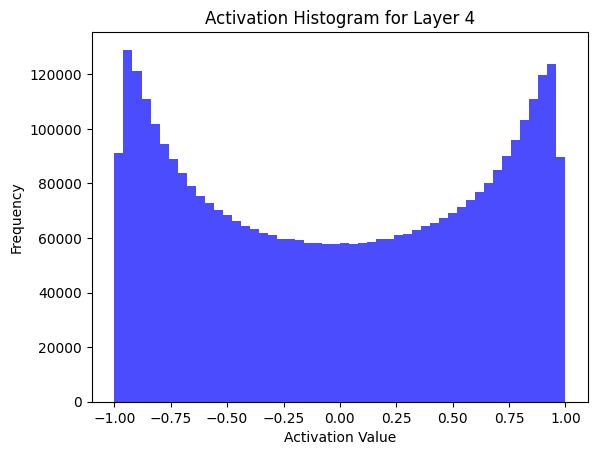

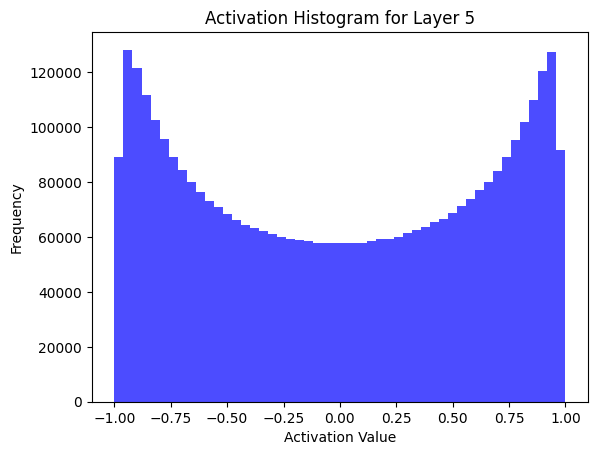

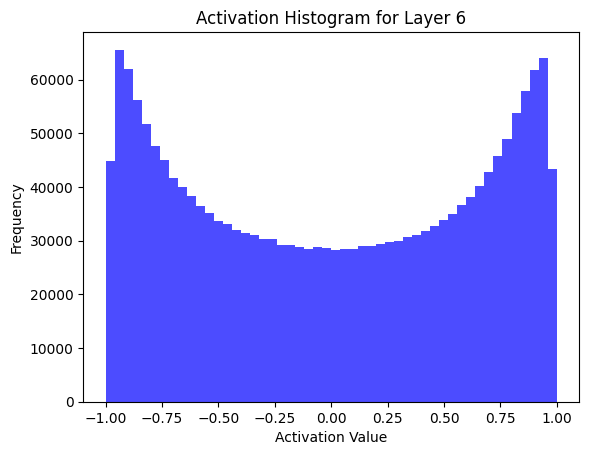

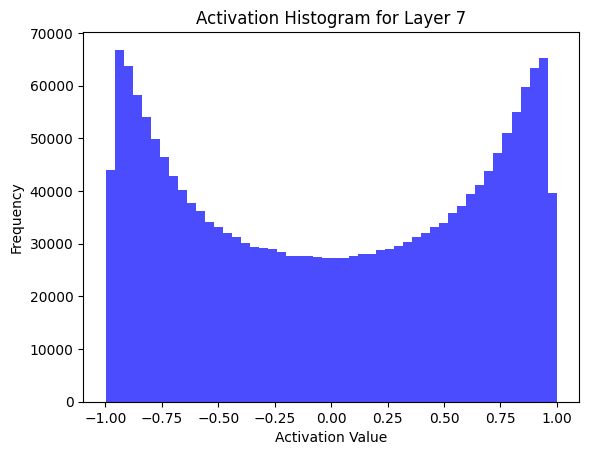

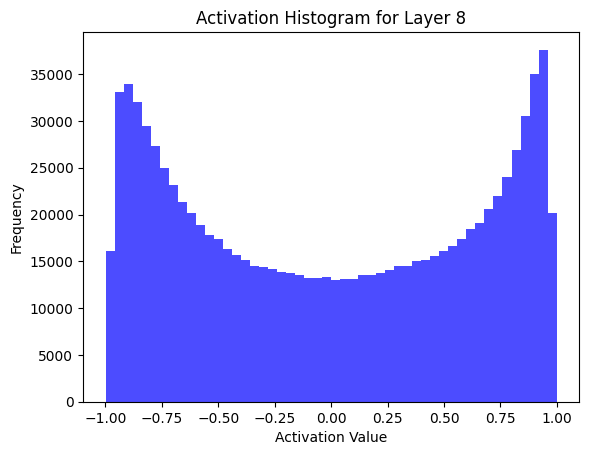

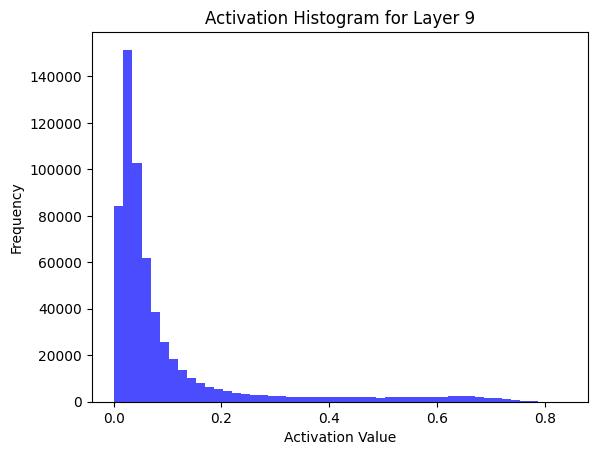

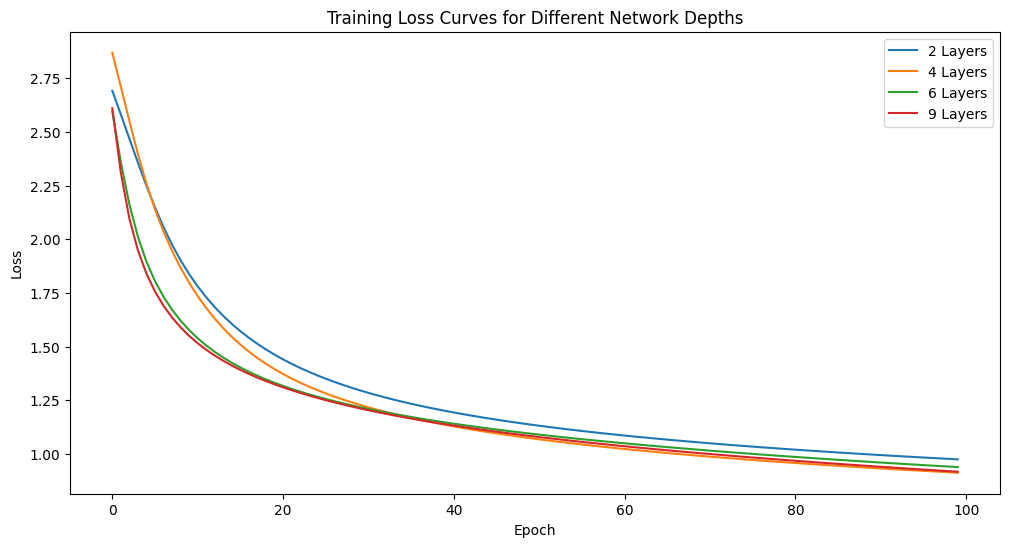

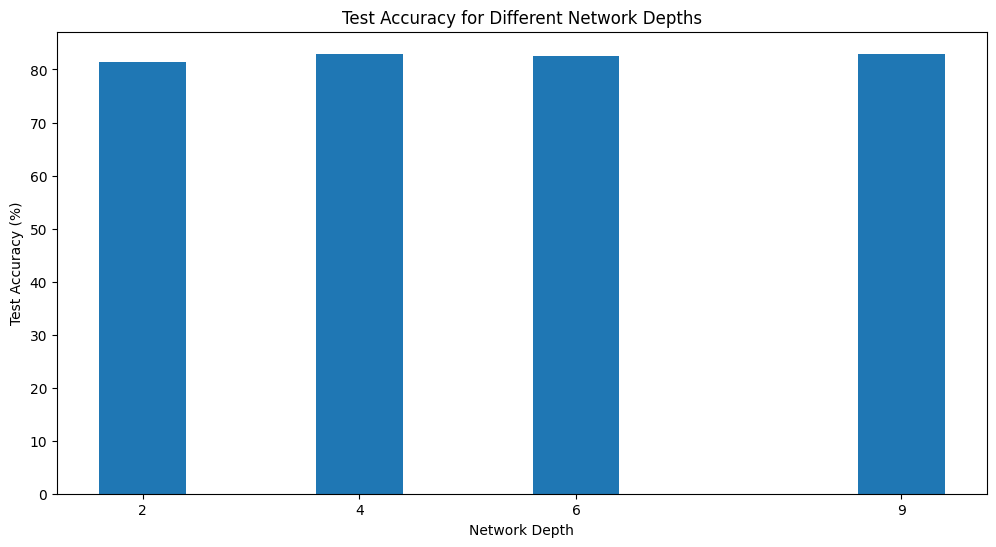

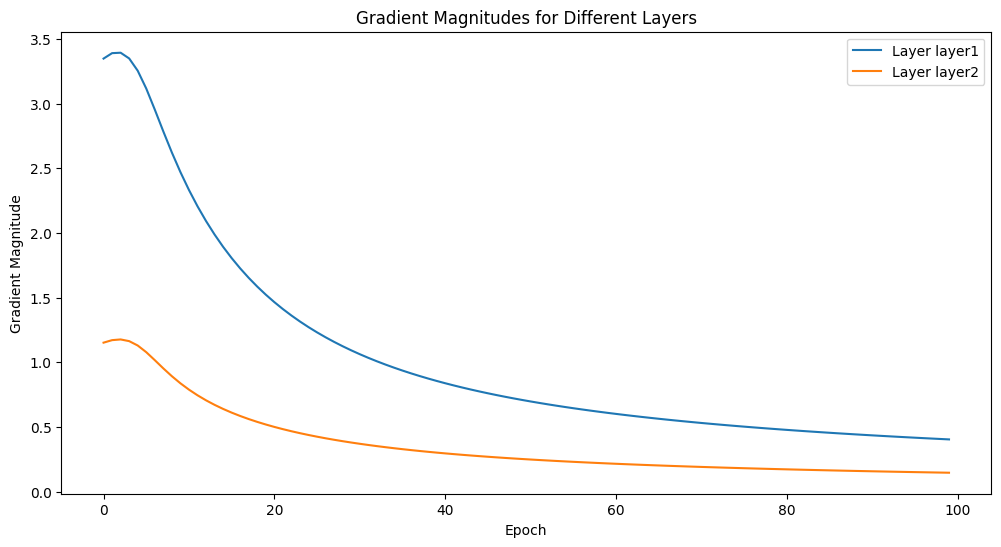

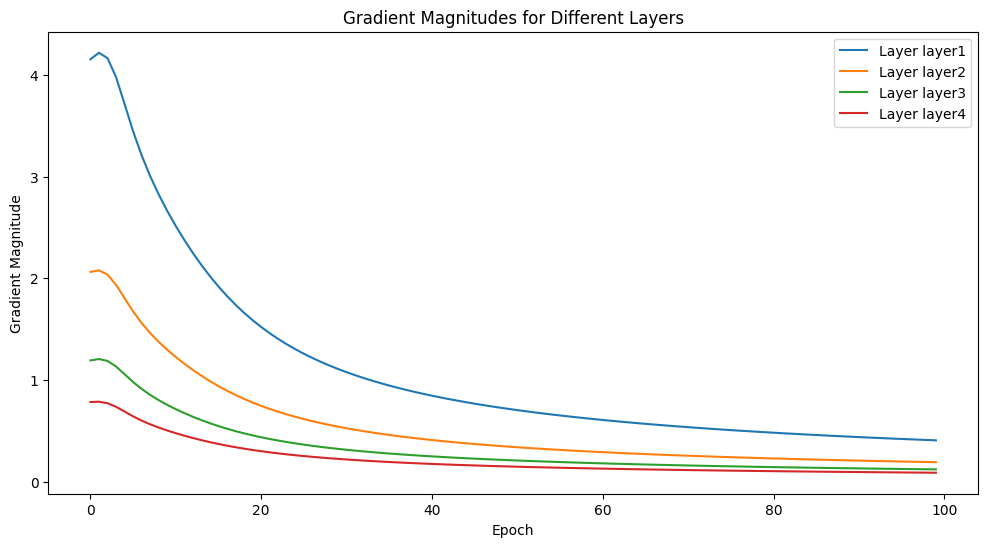

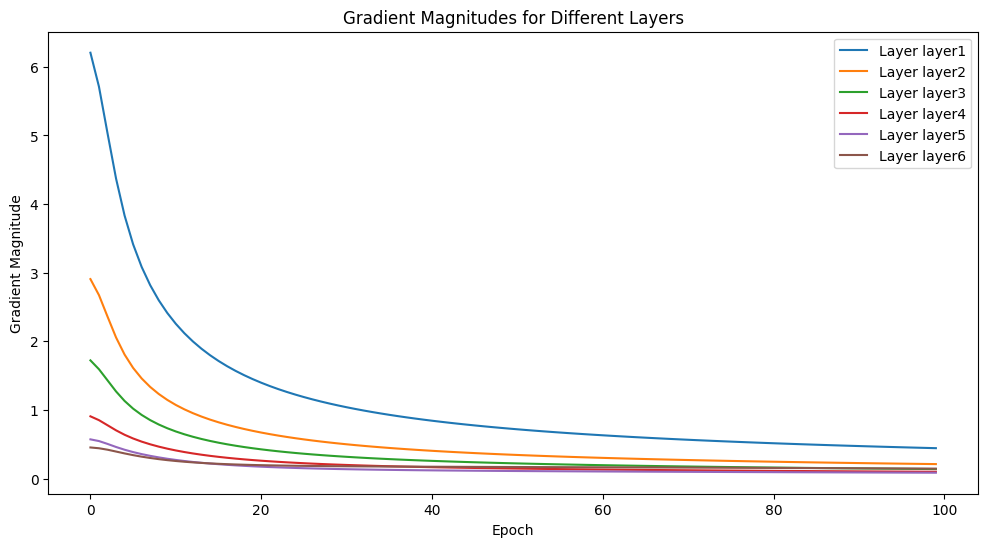

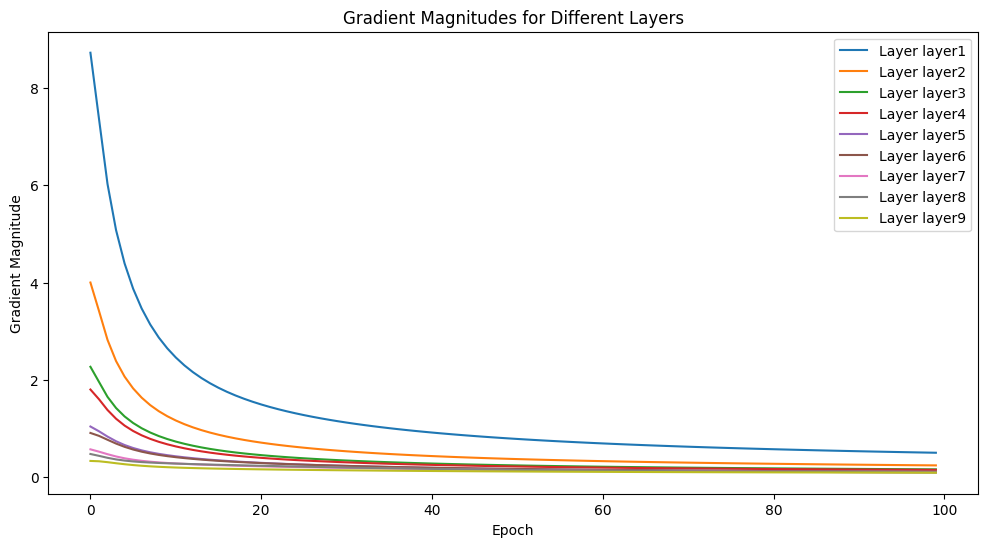

In [30]:
# Define network configurations for 3, 5, 7, and 10 layers
network_configs = [
    # 3-layer network
    ([784, 128, 10], ["tanh", "softmax"]),
    # 5-layer network
    ([784, 256, 128, 64, 10], ["tanh", "tanh", "tanh", "softmax"]),
    # 7-layer network
    ([784, 256, 128, 64, 32, 16, 10], ["tanh", "tanh", "tanh", "tanh", "tanh", "softmax"]),
    # 10-layer network
    ([784, 256, 128, 128, 64, 64, 32, 32, 16, 10], ["tanh", "tanh", "tanh", "tanh", "tanh", "tanh", "tanh", "tanh", "softmax"])
]

# Train and evaluate each network configuration
loss_histories = []
accuracies = []
gradient_magnitudes_histories = []

for layer_sizes, activations in network_configs:
    print(f"Training network with {len(layer_sizes)} layers...")
    loss_history, accuracy, gradient_magnitudes_history = train_and_evaluate_network(X_train, y_train, X_test, y_test, layer_sizes, activations, num_epochs=100, learning_rate=0.01)
    loss_histories.append(loss_history)
    accuracies.append(accuracy)
    gradient_magnitudes_histories.append(gradient_magnitudes_history)

# Plot training loss curves for networks of different depths
plt.figure(figsize=(12, 6))
for i, loss_history in enumerate(loss_histories):
    plt.plot(loss_history, label=f'{len(network_configs[i][0]) - 1} Layers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves for Different Network Depths')
plt.legend()
plt.show()

# Plot test accuracy for each network depth
plt.figure(figsize=(12, 6))
depths = [len(config[0]) - 1 for config in network_configs]
plt.bar(depths, accuracies)
plt.xlabel('Network Depth')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy for Different Network Depths')
plt.xticks(depths)
plt.show()

# Plot gradient magnitudes for different layers
plot_gradient_magnitudes(gradient_magnitudes_histories[0])  # Index 0 corresponds to the 3-layer network
plot_gradient_magnitudes(gradient_magnitudes_histories[1])  # Index 1 corresponds to the 5-layer network
plot_gradient_magnitudes(gradient_magnitudes_histories[2])  # Index 2 corresponds to the 7-layer network
plot_gradient_magnitudes(gradient_magnitudes_histories[3])  # Index 3 corresponds to the 10-layer network